In [1]:
import itertools
import sys, os

import numpy as np
import pandas as pd
from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('paper')

In [2]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error

In [3]:
%load_ext autoreload
%autoreload 2
import CCPA_lib as cp


In [4]:
sns.set_context('talk')
sns.set_style('white')

In [5]:
ppallete = 'RdYlGn'#'YlGn_d' #"BuGn_d"
porder = ['MIT0604', 'MIT9312', 'MED4', 'Natl2A', 'MIT9313']
ppallete = ['#f79934', '#face6e', '#62A586', '#7A9BC8', '#F47681', ]
# #ffd7a1
    
pedge = 'green'
apallete = "spring"
aorder = ['DE', 'DE1', '1A3', 'ATCC', 'BS11']
amarkers = ['X', 'P', 's', 'D', 'o']
aedge='orange'
epallete = ['#6cf0ba', '#d13f75', '#eeb7cb', '#b9d2d8', '#407f90']
#sns.diverging_palette(355, 217, s=74, l=50, n=4) #'Paired' # 'BrBG'# "coolwarm"
eorder = ['e1','e3', 'e4', 'e5', 'e6']
#aedge='orange'

espallete = ['#6cf0ba', '#D55282', '#538B9B']
#  604 #FCC479
#     #ffd7a1
#     #fcb14c
#     MED4 = #62A586
#     9313 #F47681
#     natl #7A9BC8

In [6]:
method_cols = [
     'cubic', 'exponential', #'exponential_segmented',
       'gompertz', 'harmonic', 'linear', 'logistic3', 'logistic4',
       'loglogistic', 'rodbard4', 'scurve', 'hyperbolic']


In [7]:
method_cols = [
    'exponential', #'exponential_segmented',
]


In [8]:
os.listdir('fcmfiles')

['fcmfiles.zip',
 'FCM_exp1_100Days.csv',
 'FCM_exp1_140Days.csv',
 'FCM_exp1_60Days.csv',
 'FCM_exp3_140Days.csv',
 'FCM_exp4_140Days.csv']

In [26]:
dflist=list()
for i in os.listdir('fcmfiles'):
    if i.endswith('.csv'):
        d = pd.read_csv(os.path.join('fcmfiles', i))
        n = os.path.splitext(i)[0]
        _, experiment, day = n.split('_')
        d['experiment'] = experiment
        d['day'] = day.replace('Days','')
        dflist.append(d)
df = pd.concat(dflist)
df.loc[df.PRO == 'C9B', 'PRO'] = 'MIT0604'

In [27]:
df.head()

,PRO,ALT,sample,PRO.1,ALT.1,experiment,day
0,MED4,1A3,1A,7.485642e+06,2.992351e+07,exp1,100
1,MED4,1A3,1B,6.720907e+06,2.159764e+07,exp1,100
2,MED4,1A3,1C,1.121335e+07,1.742056e+07,exp1,100
3,MIT9313,1A3,2A,1.415617e+06,5.134250e+06,exp1,100
4,MIT9313,1A3,2B,1.018640e+06,4.885134e+06,exp1,100


In [28]:
df.isna().sum()

PRO           45
ALT           45
sample         0
PRO.1         36
ALT.1         73
experiment     0
day            0
dtype: int64

In [29]:
df['day'] = pd.to_numeric(df['day'])

In [30]:
for c in df.columns:
    if c in ['PRO.1', 'ALT.1']:
        continue
    print(c, df[c].unique())

PRO ['MED4' 'MIT9313' 'MIT9312' 'Natl2A' 'MIT0604' nan]
ALT ['1A3' 'DE' 'DE1' 'BS11' 'ATCC' nan]
sample ['1A' '1B' '1C' '2A' '2B' '2C' '3A' '3B' '3C' '4A' '4B' '4C' '5A' '5B'
 '5C' '6A' '6B' '6C' '7A' '7B' '7C' '8A' '8B' '8C' '9A' '9B' '9C' '10A'
 '10B' '10C' '11A' '11B' '11C' '12A' '12B' '12C' '13A' '13B' '13C' '14A'
 '14B' '14C' '15A' '15B' '15C' '16A' '16B' '16C' '17A' '17B' '17C' '18A'
 '18B' '18C' '19A' '19B' '19C' '20A' '20B' '20C' '21A' '21B' '21C' '22A'
 '22B' '22C' '23A' '23B' '23C' '24A' '24B' '24C' '25A' '25B' '25C' '26A'
 '26B' '26C' '27A' '27B' '27C' '28A' '28B' '28C' '29A' '29B' '29C' '30A'
 '30B' '30C' '31A' '31B' '31C' '32A' '32B' '32C' '33A' '33B' '33C' '34A'
 '34B' '34C' '35A' '35B' '35C']
experiment ['exp1' 'exp3' 'exp4']
day [100 140  60]


In [31]:
df.dtypes

PRO            object
ALT            object
sample         object
PRO.1         float64
ALT.1         float64
experiment     object
day             int64
dtype: object

In [32]:
_df = pd.read_pickle('CCPA.pkl.gz')
_df.loc[_df.PRO == 'C9B', 'PRO'] = 'MIT0604'
df1 = _df.loc[(_df.experiment.isin(['e1']))]

In [33]:
day60 = df1.loc[(df1.day >59) & (df1.day < 61), 'day' ].unique()[0]
day100 = df1.loc[(df1.day >100) & (df1.day < 101), 'day' ].unique()[0]
day140 = df1.loc[(df1.day >139) & (df1.day < 141), 'day' ].unique()[0]
df1 = df1.loc[df1.day.isin([day60, day100,day140])]
df1['day'] = df1['day'].map({day60:60, day100:100, day140:140})
df1.experiment = 'exp1'
df1.head()


,day,experiment,sample,FL,PRO,ALT,culture,FL_orig,logFL,cumsumFL,cumsumlogFL,zscoreFL,diffFL,difflogFL,diffday,rateFL,ratelogFL,experiment_sample
39,60,exp1,1A,0.558,MED4,1A3,Co_Culture,0.558,-0.583396,95.598,11.366955,-0.376854,-0.029,-0.050666,0.631944,-0.045890,-0.080175,"e1, 1A"
68,100,exp1,1A,0.356,MED4,1A3,Co_Culture,0.356,-1.032825,112.389,-4.998736,-0.477633,-0.047,-0.124006,1.059722,-0.044351,-0.117017,"e1, 1A"
87,140,exp1,1A,0.079,MED4,1A3,Co_Culture,0.079,-2.538307,115.576,-42.125818,-0.615830,-0.009,-0.107889,1.900000,-0.004737,-0.056784,"e1, 1A"
127,60,exp1,1B,0.680,MED4,1A3,Co_Culture,0.680,-0.385662,101.031,15.665516,-0.372846,0.121,0.195943,0.631944,0.191473,0.310064,"e1, 1B"
156,100,exp1,1B,0.403,MED4,1A3,Co_Culture,0.403,-0.908819,120.126,3.203152,-0.513839,-0.045,-0.105857,1.059722,-0.042464,-0.099891,"e1, 1B"


In [34]:
# add the FL numbers from experiment1 to the table
df = df.merge(df1.loc[:,['day', 'sample', 'FL', 'experiment']], 
        how='left', on=['experiment','sample', 'day'], validate='one_to_one')

In [35]:
df.head()

,PRO,ALT,sample,PRO.1,ALT.1,experiment,day,FL
0,MED4,1A3,1A,7.485642e+06,2.992351e+07,exp1,100,0.356
1,MED4,1A3,1B,6.720907e+06,2.159764e+07,exp1,100,0.403
2,MED4,1A3,1C,1.121335e+07,1.742056e+07,exp1,100,0.626
3,MIT9313,1A3,2A,1.415617e+06,5.134250e+06,exp1,100,0.101
4,MIT9313,1A3,2B,1.018640e+06,4.885134e+06,exp1,100,0.050


In [36]:
dfall = df.copy()
df.dropna(axis=0, subset=['PRO', 'ALT'], inplace=True)

In [38]:
dfall.isna().sum()

PRO            45
ALT            45
sample          0
PRO.1          36
ALT.1          73
experiment      0
day             0
FL            207
dtype: int64

In [45]:
# remove the rows where some data is missing. ;leave rows were no data is found but should not be there (e.g. ALT in axenic pro)
dfall = dfall.loc[((~dfall['PRO.1'].isna() & ~dfall['PRO'].isna()) |
          (~dfall['ALT.1'].isna() & ~dfall['ALT'].isna()) )
         ]

In [46]:
dfall.isna().sum()

PRO            28
ALT            45
sample          0
PRO.1          28
ALT.1          50
experiment      0
day             0
FL            184
dtype: int64

In [47]:
dfall.head()

,PRO,ALT,sample,PRO.1,ALT.1,experiment,day,FL
0,MED4,1A3,1A,7.485642e+06,2.992351e+07,exp1,100,0.356
1,MED4,1A3,1B,6.720907e+06,2.159764e+07,exp1,100,0.403
2,MED4,1A3,1C,1.121335e+07,1.742056e+07,exp1,100,0.626
3,MIT9313,1A3,2A,1.415617e+06,5.134250e+06,exp1,100,0.101
4,MIT9313,1A3,2B,1.018640e+06,4.885134e+06,exp1,100,0.050


In [111]:
dfall['PRO, ALT'] = dfall['PRO'] +', '+ dfall['ALT']
dfall.loc[dfall.PRO.isna(), 'PRO, ALT'] = dfall.loc[dfall.PRO.isna(), 'ALT']
dfall.loc[dfall.ALT.isna(), 'PRO, ALT'] = dfall.loc[dfall.ALT.isna(), 'PRO']

dfall['culture'] = 'Co_Culture'
dfall.loc[dfall.PRO.isna(), 'culture'] = 'ALT only'
dfall.loc[dfall.ALT.isna(), 'culture'] = 'PRO only'
dfall['Total'] = dfall['ALT.1'] + dfall['PRO.1']
dfall.loc[dfall.PRO.isna(), 'Total'] = dfall.loc[dfall.PRO.isna(), 'ALT.1']
dfall.loc[dfall.ALT.isna(), 'Total'] = dfall.loc[dfall.ALT.isna(), 'PRO.1']


In [106]:
dfall.head()

,PRO,ALT,sample,PRO.1,ALT.1,experiment,day,FL,"PRO, ALT",culture,Total
0,MED4,1A3,1A,7.485642e+06,2.992351e+07,exp1,100,0.356,"MED4, 1A3",Co_Culture,3.740915e+07
1,MED4,1A3,1B,6.720907e+06,2.159764e+07,exp1,100,0.403,"MED4, 1A3",Co_Culture,2.831855e+07
2,MED4,1A3,1C,1.121335e+07,1.742056e+07,exp1,100,0.626,"MED4, 1A3",Co_Culture,2.863391e+07
3,MIT9313,1A3,2A,1.415617e+06,5.134250e+06,exp1,100,0.101,"MIT9313, 1A3",Co_Culture,6.549867e+06
4,MIT9313,1A3,2B,1.018640e+06,4.885134e+06,exp1,100,0.050,"MIT9313, 1A3",Co_Culture,5.903774e+06


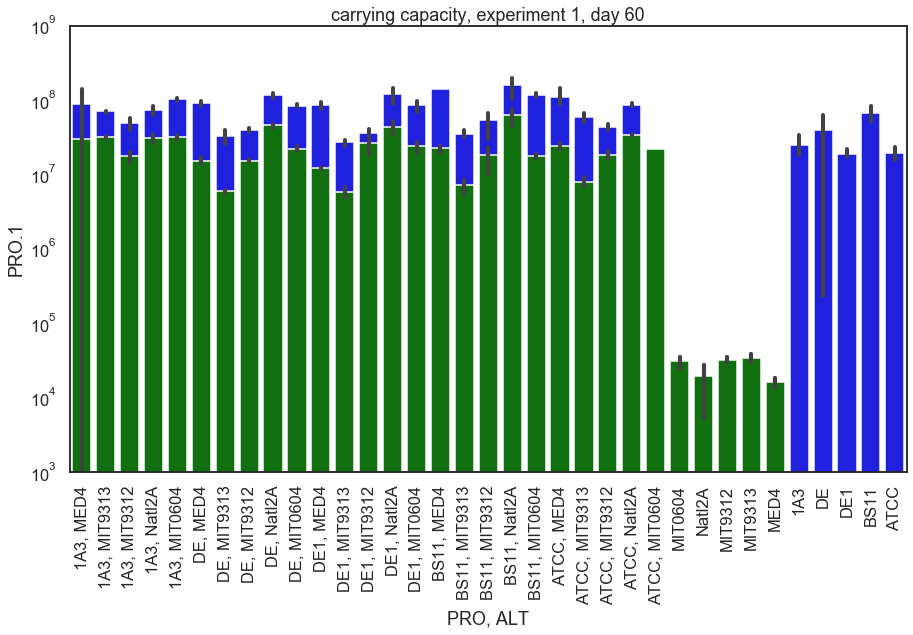

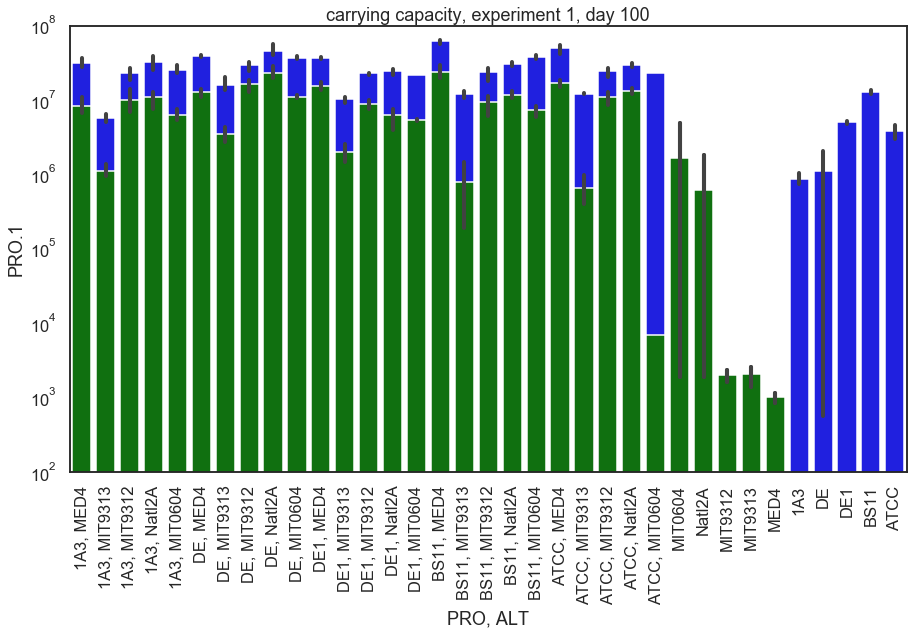

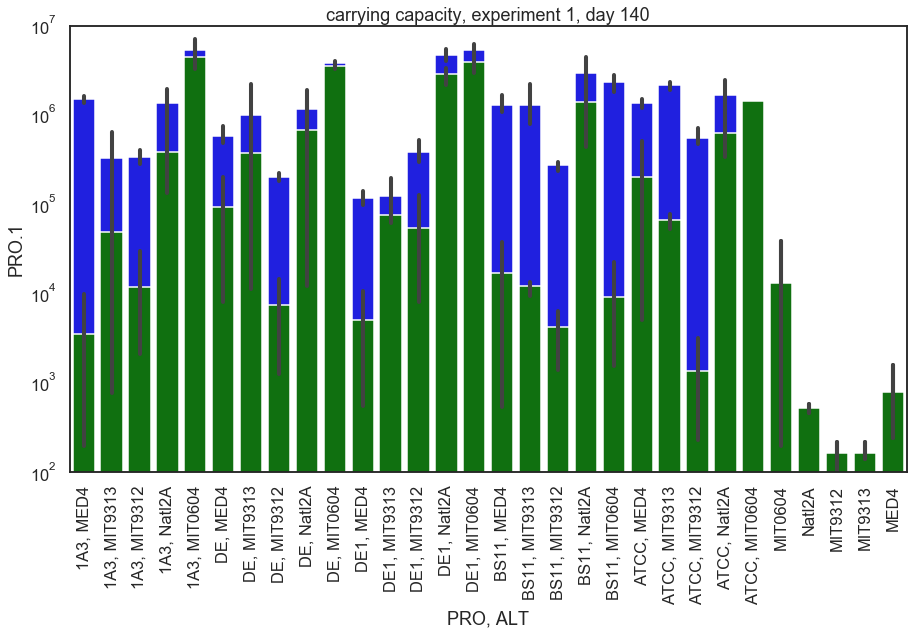

In [109]:
for d in [60,100,140]:
    ax = sns.barplot(data=dfall.loc[(dfall.experiment == 'exp1') & (dfall.day == d)].fillna(0),
                x ='PRO, ALT', 
                     #hue='PRO',
                #hue='culture', 
                     y='Total', color='blue')

    ax = sns.barplot(data=dfall.loc[(dfall.experiment == 'exp1') & (dfall.day == d)].fillna(0),
                            x ='PRO, ALT',
                     #hue='PRO',
                #hue='culture', 
                     y='PRO.1', color='green', ax=ax)
    #ax = sns.barplot(data=dfall.loc[(dfall.experiment == 'exp1') & (dfall.day == d)].fillna(0),
    #                        x ='PRO, ALT', 
    #            #hue='culture', 
    #                 y='ALT.1', color='red', ax=ax)
    #plt.legend(None)
    #ax.get_legend().remove()
    #ax.xticks(rotation=90)
    plt.xticks(rotation='vertical')
    plt.yscale('log')
    plt.title(f'carrying capacity, experiment 1, day {d}')
    plt.show()


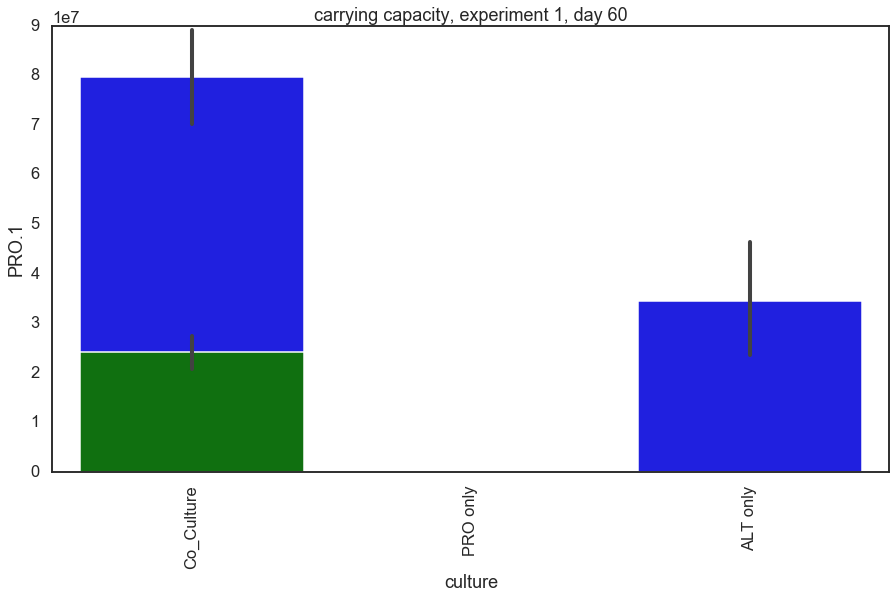

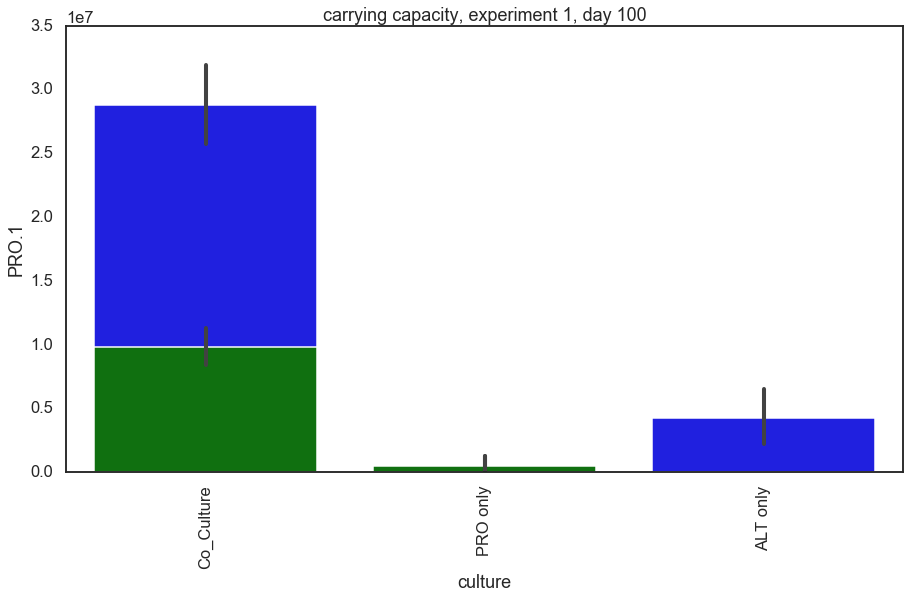

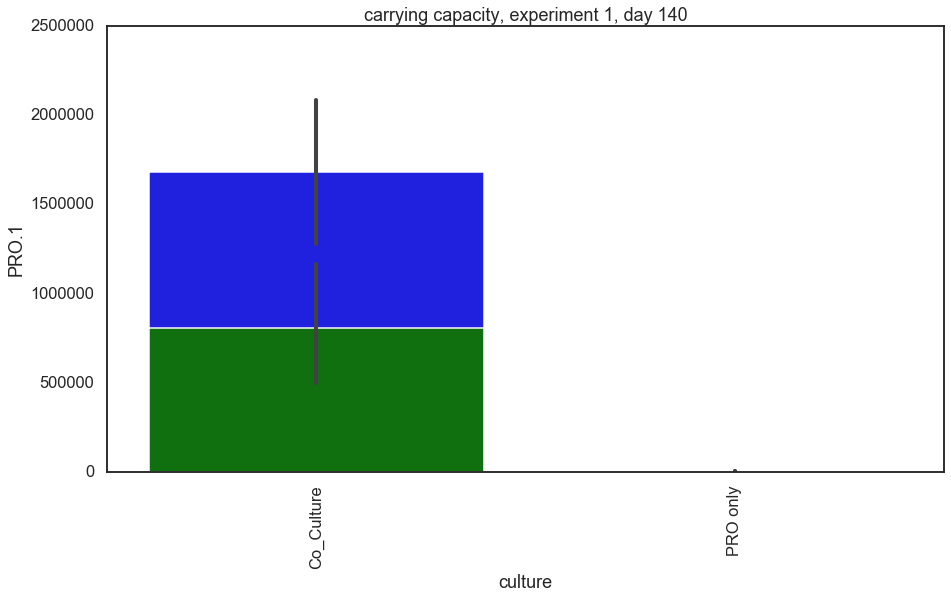

In [124]:
for d in [60,100,140]:
    ax = sns.barplot(data=dfall.loc[(dfall.experiment == 'exp1') & (dfall.day == d)].fillna(0),
                #units ='PRO, ALT', 
                     #hue='PRO',
                x='culture', 
                     y='Total', color='blue')

    ax = sns.barplot(data=dfall.loc[(dfall.experiment == 'exp1') & (dfall.day == d)].fillna(0),
                            #units ='PRO, ALT',
                     #hue='PRO',
                x='culture', 
                     y='PRO.1', color='green', ax=ax)
    #ax = sns.barplot(data=dfall.loc[(dfall.experiment == 'exp1') & (dfall.day == d)].fillna(0),
    #                        x ='PRO, ALT', 
    #            #hue='culture', 
    #                 y='ALT.1', color='red', ax=ax)
    #plt.legend(None)
    #ax.get_legend().remove()
    #ax.xticks(rotation=90)
    #plt.xticks(rotation='vertical')
    plt.yscale('log')
    plt.title(f'carrying capacity, experiment 1, day {d}')
    plt.show()


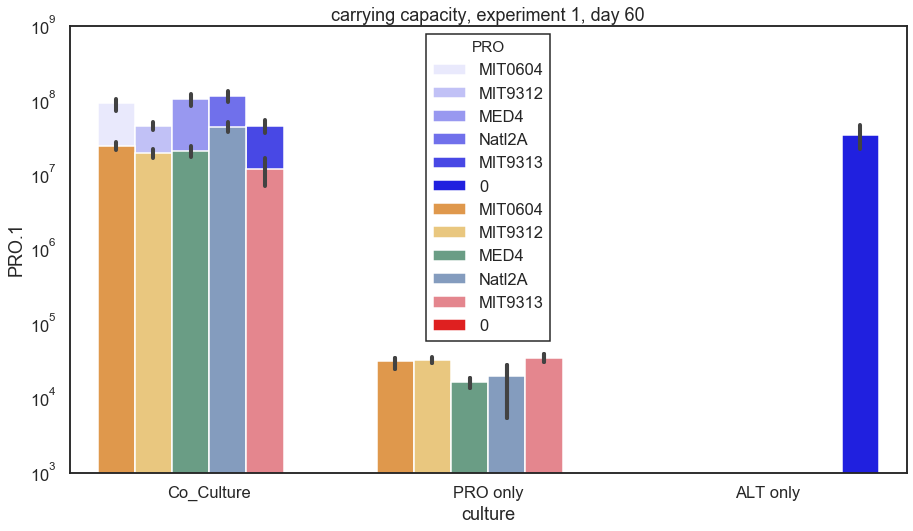

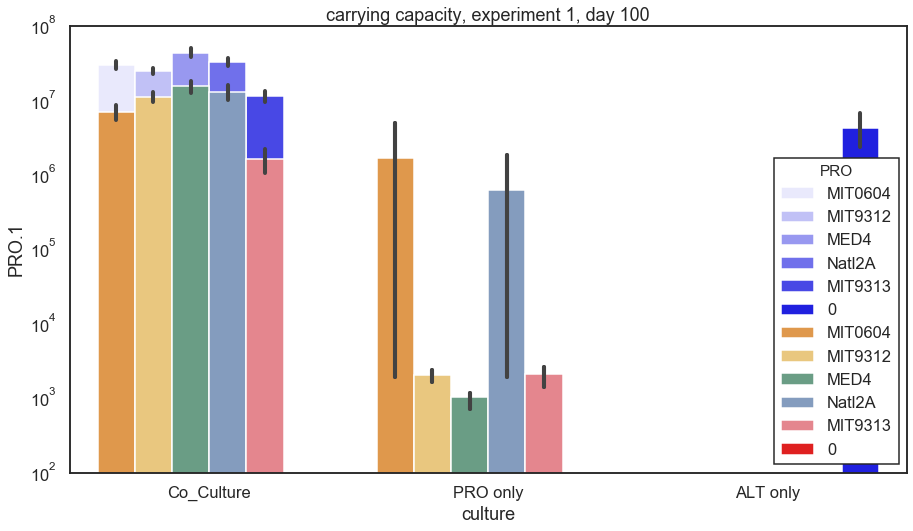

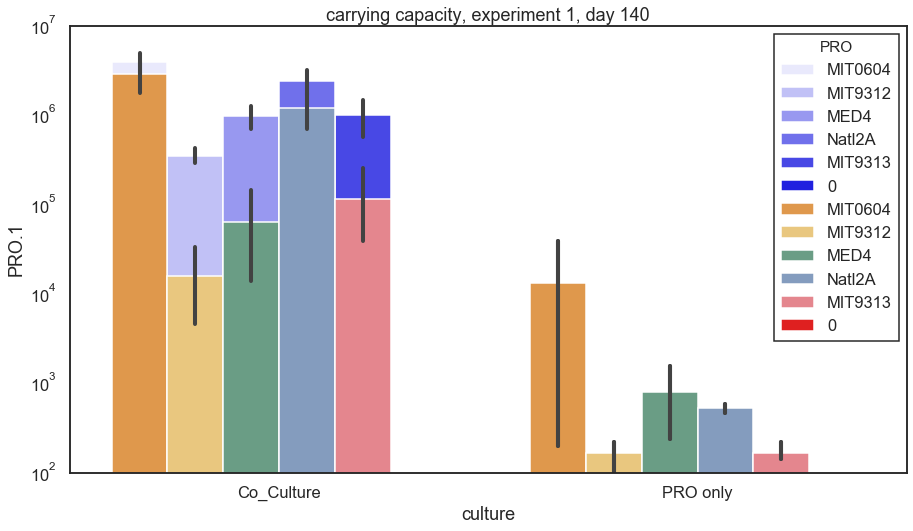

In [132]:
for d in [60,100,140]:
    ax = sns.barplot(data=dfall.loc[(dfall.experiment == 'exp1') & (dfall.day == d)].fillna(0),
                #units ='PRO, ALT', 
                     hue='PRO',
                     hue_order=porder+ [0],
                x='culture', 
                     y='Total', color='blue')

    ax = sns.barplot(data=dfall.loc[(dfall.experiment == 'exp1') & (dfall.day == d)].fillna(0),
                            #units ='PRO, ALT',
                     hue='PRO',
                    hue_order=porder+ [0],
                     palette=ppallete + ['red'],

                x='culture', 
                     y='PRO.1', #color='green', 
                     ax=ax)
    #ax = sns.barplot(data=dfall.loc[(dfall.experiment == 'exp1') & (dfall.day == d)].fillna(0),
    #                        x ='PRO, ALT', 
    #            #hue='culture', 
    #                 y='ALT.1', color='red', ax=ax)
    #plt.legend(None)
    #ax.get_legend().remove()
    #ax.xticks(rotation=90)
    #plt.xticks(rotation='vertical')
    plt.yscale('log')
    plt.title(f'carrying capacity, experiment 1, day {d}')
    plt.show()


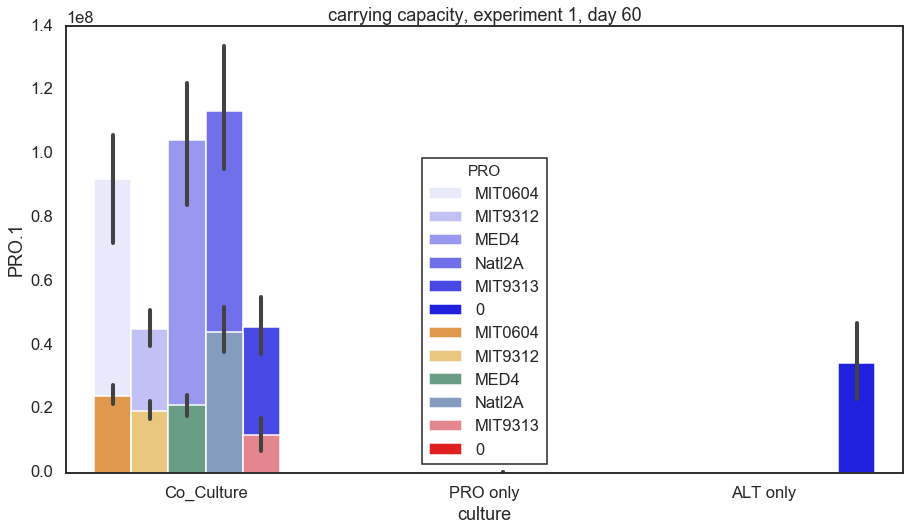

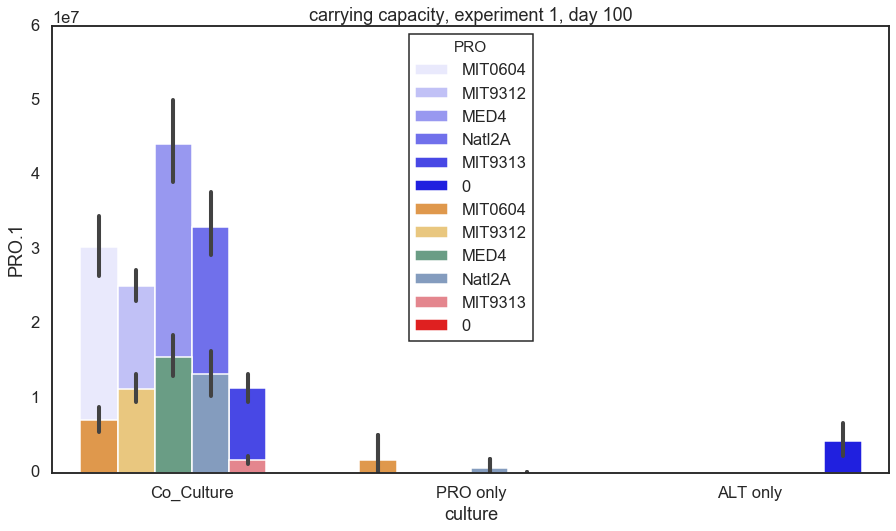

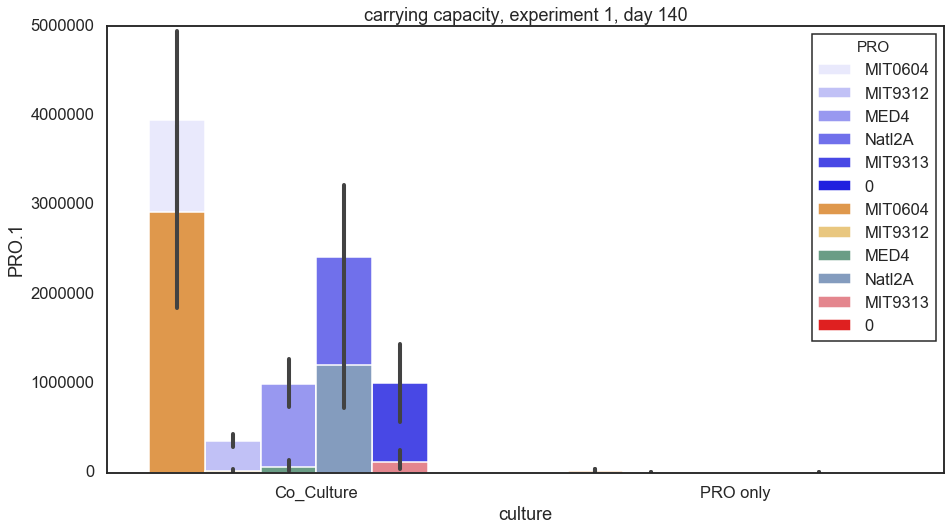

In [135]:
for d in [60,100,140]:
    ax = sns.barplot(data=dfall.loc[(dfall.experiment == 'exp1') & (dfall.day == d)].fillna(0),
                #units ='PRO, ALT', 
                     hue='PRO',
                     hue_order=porder+ [0],
                x='culture', 
                     y='Total', color='blue'
                    )

    ax = sns.barplot(data=dfall.loc[(dfall.experiment == 'exp1') & (dfall.day == d)].fillna(0),
                            #units ='PRO, ALT',
                     hue='PRO',
                    hue_order=porder+ [0],
                     palette=ppallete + ['red'],

                x='culture', 
                     y='PRO.1', #color='green', 
                     ax=ax)
    #ax = sns.barplot(data=dfall.loc[(dfall.experiment == 'exp1') & (dfall.day == d)].fillna(0),
    #                        x ='PRO, ALT', 
    #            #hue='culture', 
    #                 y='ALT.1', color='red', ax=ax)
    #plt.legend(None)
    #ax.get_legend().remove()
    #ax.xticks(rotation=90)
    #plt.xticks(rotation='vertical')
    #plt.yscale('log')
    plt.title(f'carrying capacity, experiment 1, day {d}')
    plt.show()


In [114]:
dfall['PRO, ALT'].unique()

array(['MED4, 1A3', 'MIT9313, 1A3', 'MIT9312, 1A3', 'Natl2A, 1A3',
       'MIT0604, 1A3', 'MED4, DE', 'MIT9313, DE', 'MIT9312, DE',
       'Natl2A, DE', 'MIT0604, DE', 'MED4, DE1', 'MIT9313, DE1',
       'MIT9312, DE1', 'Natl2A, DE1', 'MIT0604, DE1', 'MED4, BS11',
       'MIT9313, BS11', 'MIT9312, BS11', 'Natl2A, BS11', 'MIT0604, BS11',
       'MED4, ATCC', 'MIT9313, ATCC', 'MIT9312, ATCC', 'Natl2A, ATCC',
       'MIT0604, ATCC', 'MIT0604', 'Natl2A', 'MIT9312', 'MIT9313', 'MED4',
       '1A3', 'DE', 'DE1', 'BS11', 'ATCC'], dtype=object)

In [120]:
order_list = [f'{p}, {a}' if a is not None else p for p  in porder for a in (aorder + [None])]
order_list = order_list + aorder


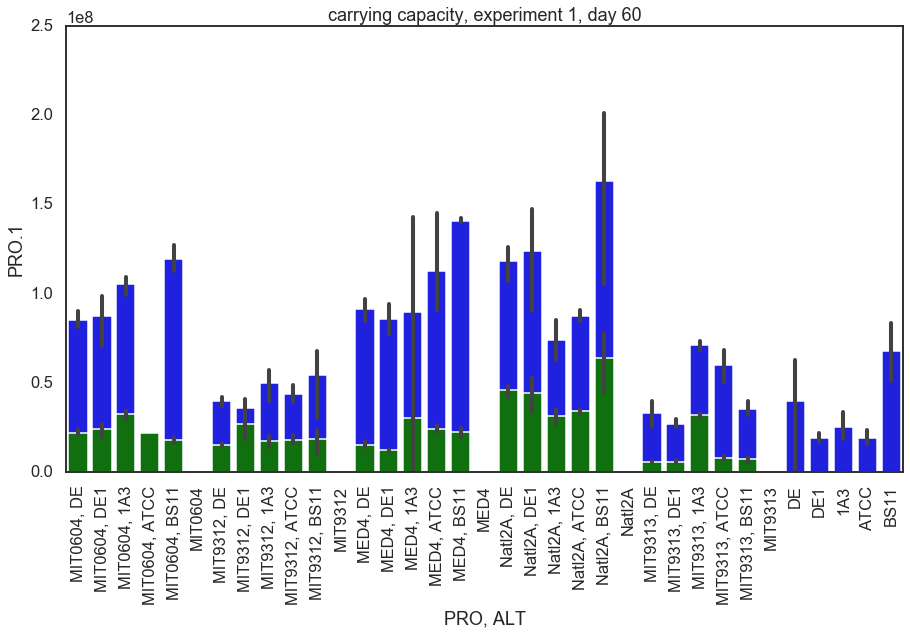

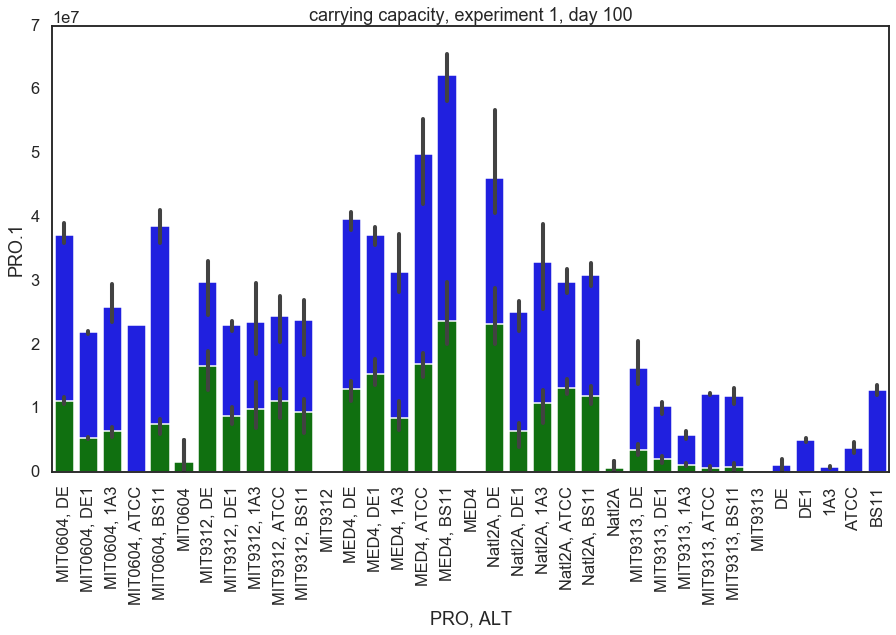

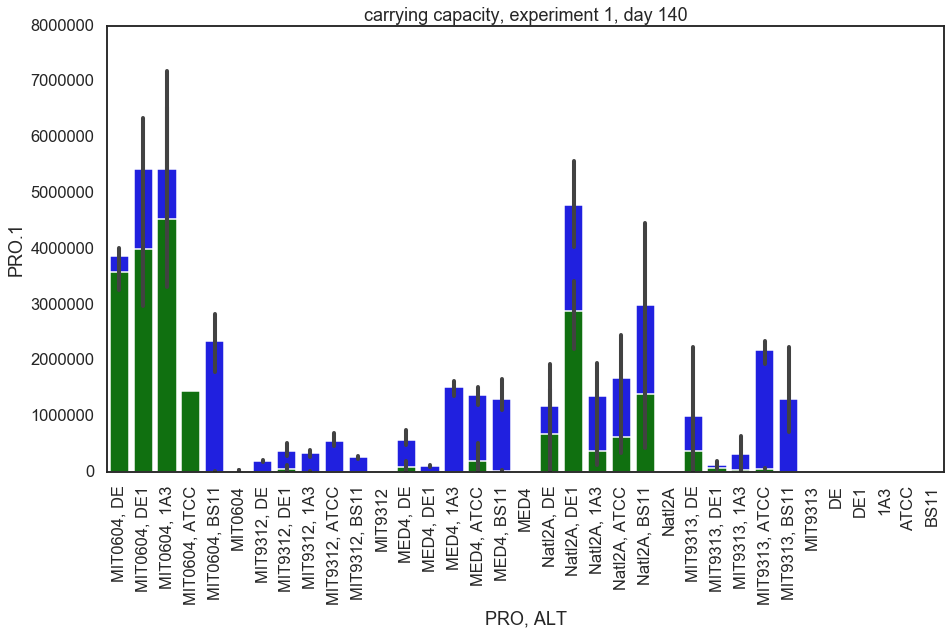

In [121]:
for d in [60,100,140]:
    ax = sns.barplot(data=dfall.loc[(dfall.experiment == 'exp1') & (dfall.day == d)].fillna(0),
                x ='PRO, ALT', 
                     #hue='PRO',
                #hue='culture', 
                     order=order_list,
                     y='Total', color='blue')

    ax = sns.barplot(data=dfall.loc[(dfall.experiment == 'exp1') & (dfall.day == d)].fillna(0),
                            x ='PRO, ALT',
                     #hue='PRO',
                     order=order_list,
                #hue='culture', 
                     y='PRO.1', color='green', ax=ax)
    #ax = sns.barplot(data=dfall.loc[(dfall.experiment == 'exp1') & (dfall.day == d)].fillna(0),
    #                        x ='PRO, ALT', 
    #            #hue='culture', 
    #                 y='ALT.1', color='red', ax=ax)
    #plt.legend(None)
    #ax.get_legend().remove()
    #ax.xticks(rotation=90)
    plt.xticks(rotation='vertical')
    #plt.yscale('log')
    plt.title(f'carrying capacity, experiment 1, day {d}')
    plt.show()


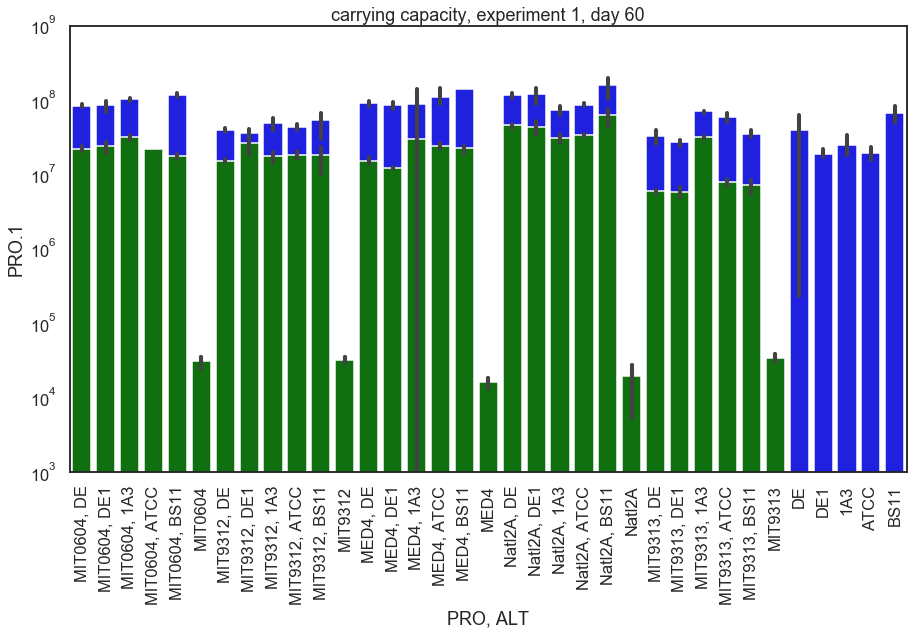

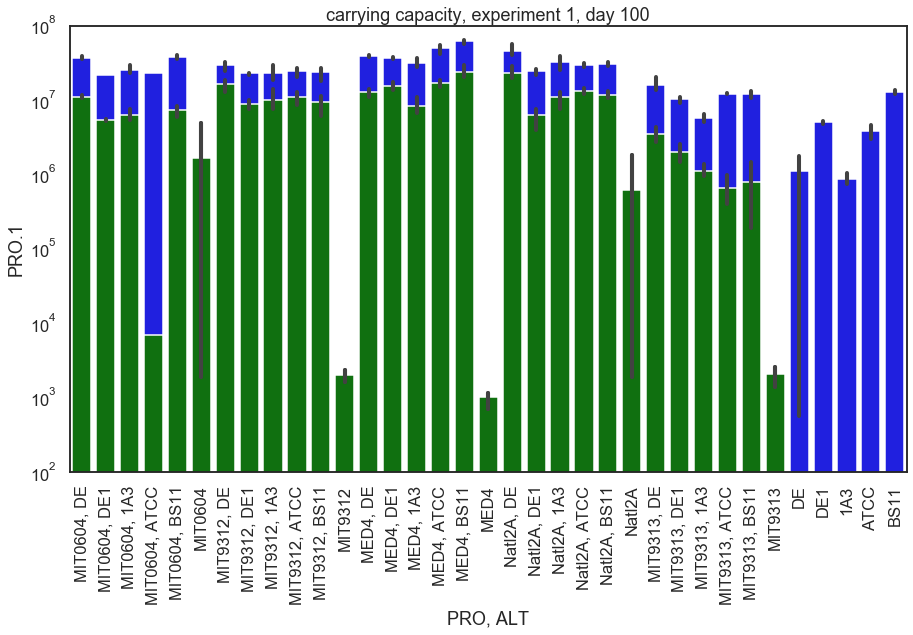

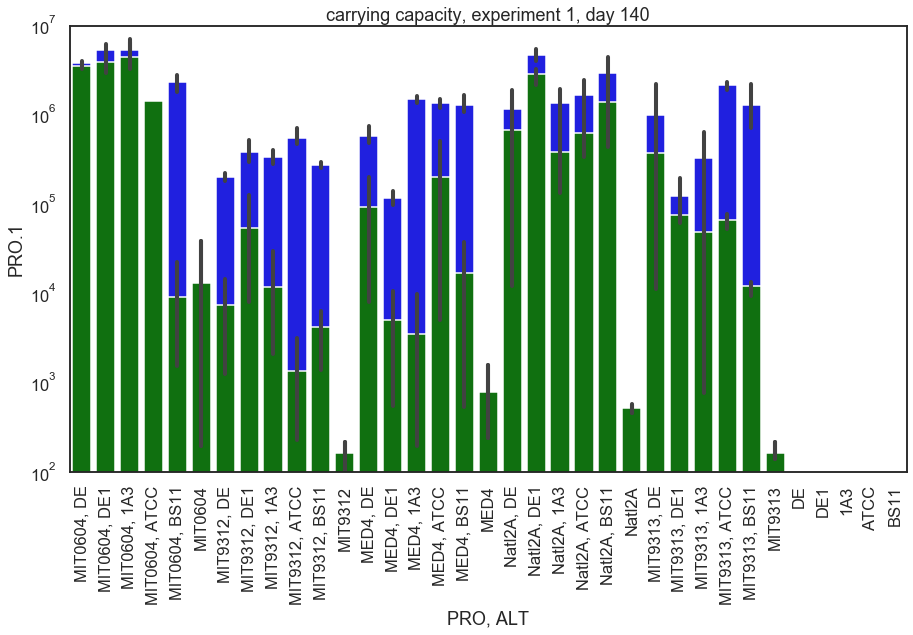

In [123]:
for d in [60,100,140]:
    ax = sns.barplot(data=dfall.loc[(dfall.experiment == 'exp1') & (dfall.day == d)].fillna(0),
                x ='PRO, ALT', 
                     #hue='PRO',
                #hue='culture', 
                     order=order_list,
                     y='Total', color='blue')

    ax = sns.barplot(data=dfall.loc[(dfall.experiment == 'exp1') & (dfall.day == d)].fillna(0),
                            x ='PRO, ALT',
                     #hue='PRO',
                     order=order_list,
                #hue='culture', 
                     y='PRO.1', color='green', ax=ax)
    #ax = sns.barplot(data=dfall.loc[(dfall.experiment == 'exp1') & (dfall.day == d)].fillna(0),
    #                        x ='PRO, ALT', 
    #            #hue='culture', 
    #                 y='ALT.1', color='red', ax=ax)
    #plt.legend(None)
    #ax.get_legend().remove()
    #ax.xticks(rotation=90)
    plt.xticks(rotation='vertical')
    plt.yscale('log')
    plt.title(f'carrying capacity, experiment 1, day {d}')
    plt.show()


Text(0.5, 1, 'ALT cell counts, experiment 1 ')

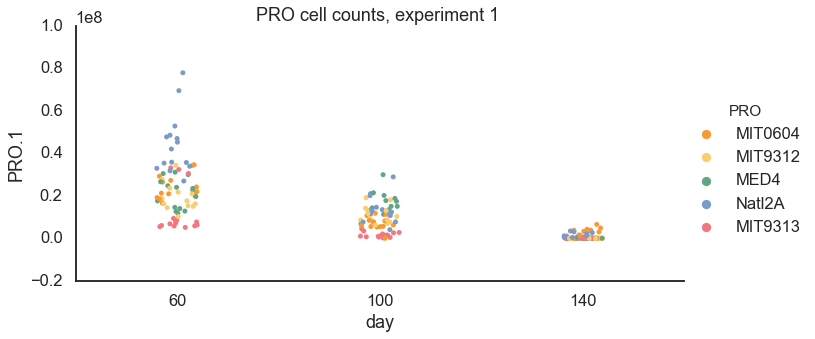

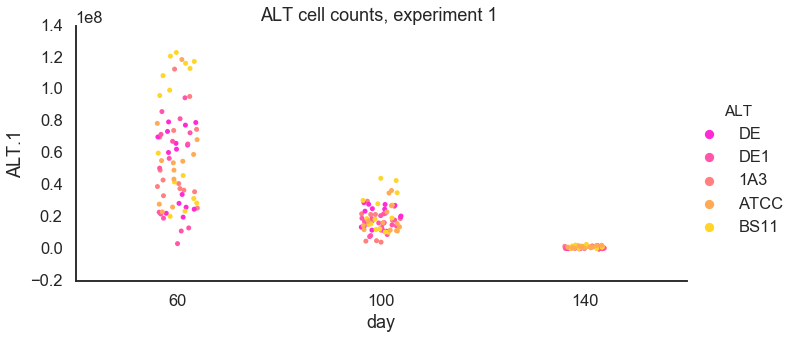

In [37]:
g=sns.catplot(data=df.loc[df.experiment == 'exp1'],
             x='day', y='PRO.1', hue='PRO', 
              aspect=2,
              hue_order=porder, palette=ppallete)
#plt.ylim((0,))
plt.title('PRO cell counts, experiment 1 ')
g=sns.catplot(data=df.loc[df.experiment == 'exp1'],
             x='day', y='ALT.1', hue='ALT',
              aspect=2,
              hue_order=aorder, palette=apallete)
#plt.ylim((0,))
plt.title('ALT cell counts, experiment 1 ')

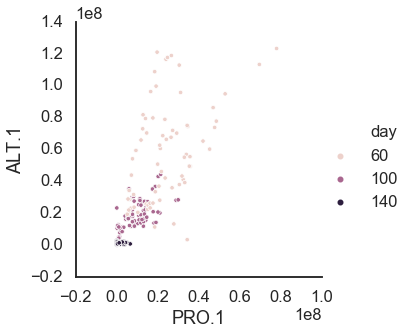

In [20]:
g= sns.relplot(data=df.loc[df.experiment=='exp1'], 
               x='PRO.1', y='ALT.1', hue='day', legend='full'
            #hue_order=porder, palette=ppallete, style_order=aorder, markers=amarkers,
           )


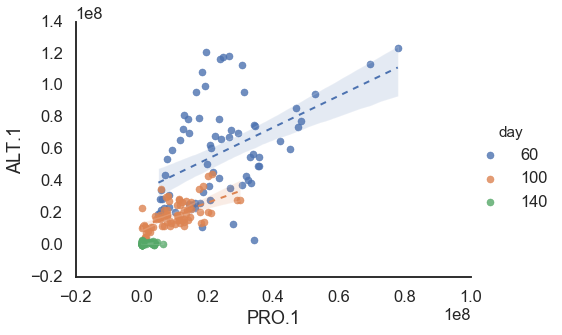

In [21]:
sns.lmplot(data=df.loc[df.experiment=='exp1'], 
           x='PRO.1', y='ALT.1', hue='day', legend='full',
           #hue_order=oorder, palette=opalette,
           aspect=1.4, #markers=True,
           #x_ci='sd',
           scatter=True,
           scatter_kws=dict(s=50),
           line_kws=dict(linewidth=2, linestyle='dashed'),
           truncate=True
          )
#plt.title('Number of alternative ORFs vs genome size')
#plt.ylabel('Number of ORFs')

Text(0.5, 1.1, 'ALT vs PRO cell numbers (experiment 1, days 60,100,140)')

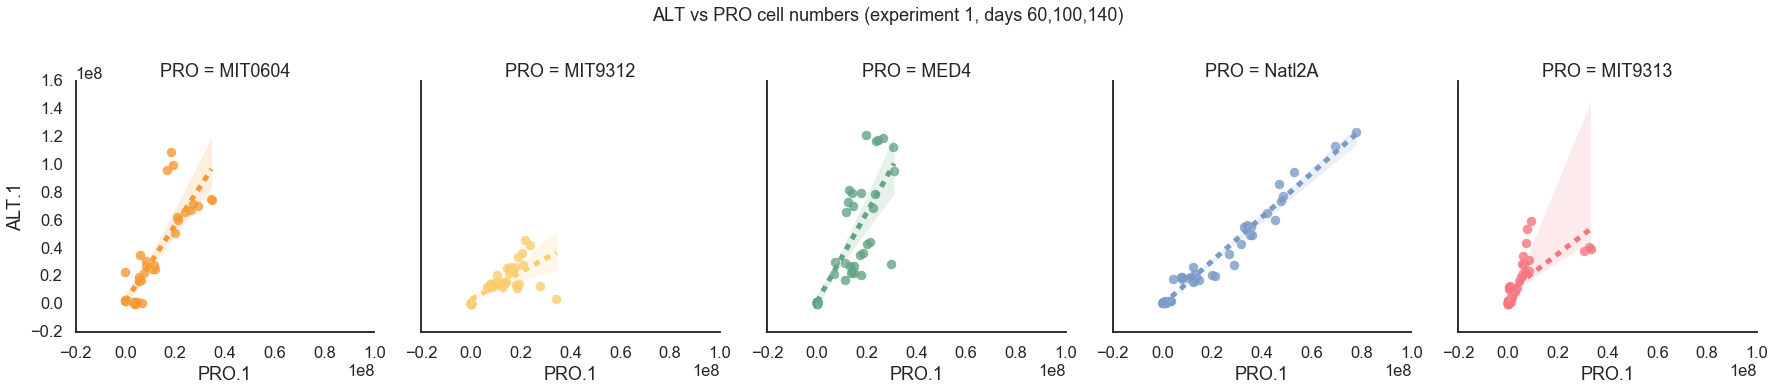

In [22]:
sns.lmplot(data=df.loc[df.experiment=='exp1'], 
           x='PRO.1', y='ALT.1', col='PRO', hue='PRO', legend='full',
           col_order=porder, hue_order=porder, palette=ppallete,
           #aspect=1.4, #markers=True,
           #x_ci='sd',
           scatter=True,
           scatter_kws=dict(s=80),
           line_kws=dict(linewidth=5, linestyle='dashed'),
           truncate=True
          )
plt.suptitle('ALT vs PRO cell numbers (experiment 1, days 60,100,140)', y=1.1)
#plt.ylabel('Number of ORFs')

Text(0.5, 1.1, 'ALT vs PRO cell numbers (experiment 1, days 60,100,140)')

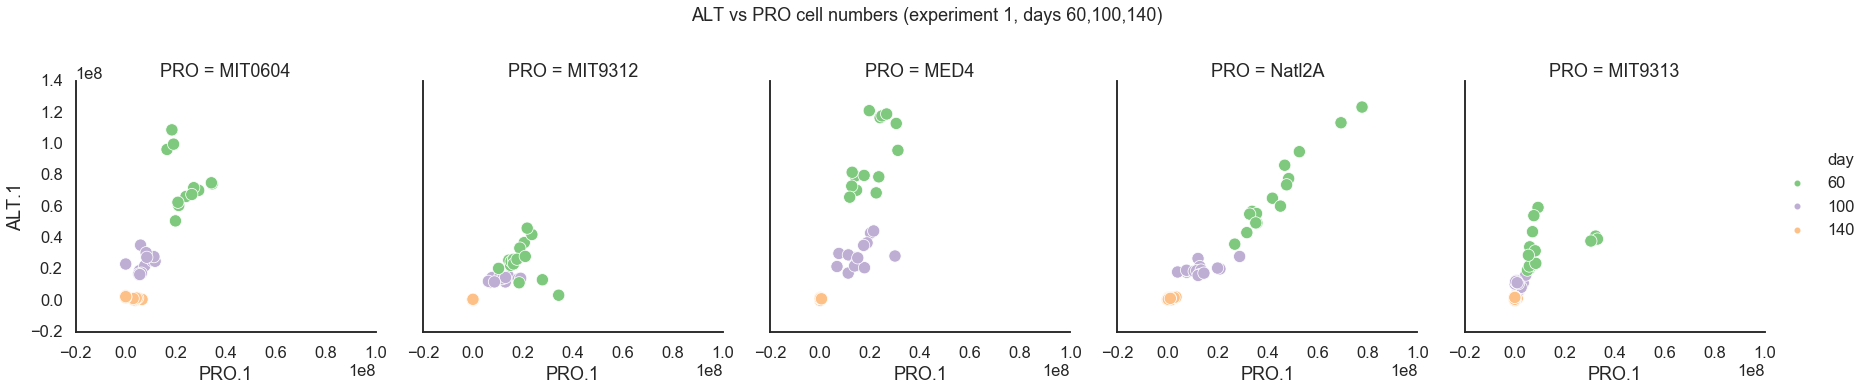

In [23]:
sns.relplot(data=df.loc[df.experiment=='exp1'], 
           x='PRO.1', y='ALT.1', col='PRO', hue='day', legend='full',
           col_order=porder, #hue_order=porder, palette=ppallete,
           #aspect=1.4, #markers=True,
           #x_ci='sd',
           #scatter=True,
           #scatter_kws=dict(s=80),
           #line_kws=dict(linewidth=5, linestyle='dashed'),
           #truncate=True
            s=150,
            palette='Accent'
          )
plt.suptitle('ALT vs PRO cell numbers (experiment 1, days 60,100,140)', y=1.1)
#plt.ylabel('Number of ORFs')

Text(0.5, 1.1, 'ALT vs PRO cell numbers (experiment 1, days 60,100,140)')

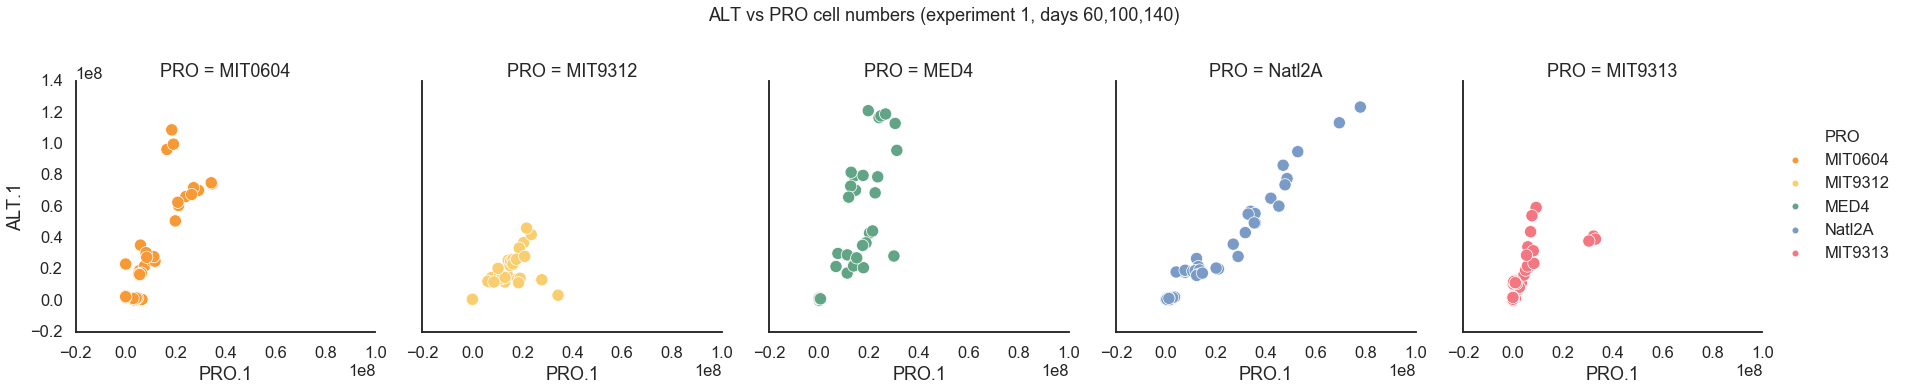

In [24]:
sns.relplot(data=df.loc[df.experiment=='exp1'], 
           x='PRO.1', y='ALT.1', col='PRO', hue='PRO', legend='full',
           col_order=porder, hue_order=porder, palette=ppallete,
           #aspect=1.4, #markers=True,
           #x_ci='sd',
            s=150,
           #scatter=True,
           #scatter_kws=dict(s=80),
           #line_kws=dict(linewidth=5, linestyle='dashed'),
           #truncate=True
          )
plt.suptitle('ALT vs PRO cell numbers (experiment 1, days 60,100,140)', y=1.1)
#plt.ylabel('Number of ORFs')

Text(0.5, 1.1, 'ALT vs PRO cell numbers (experiment 1, days 60,100,140)')

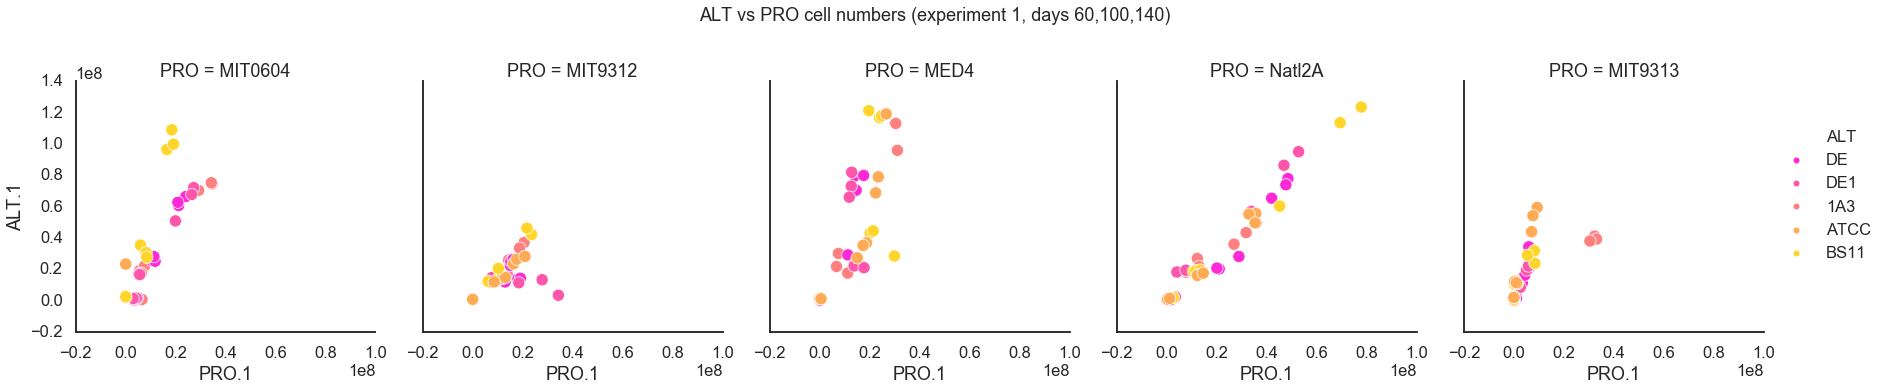

In [25]:
sns.relplot(data=df.loc[df.experiment=='exp1'], 
           x='PRO.1', y='ALT.1', col='PRO', hue='ALT', legend='full',
           col_order=porder, hue_order=aorder, palette=apallete,
           #aspect=1.4, #markers=True,
           #x_ci='sd',
           #scatter=True,
            s=150
           #scatter_kws=dict(s=80),
           #line_kws=dict(linewidth=5, linestyle='dashed'),
           #truncate=True
          )
plt.suptitle('ALT vs PRO cell numbers (experiment 1, days 60,100,140)', y=1.1)
#plt.ylabel('Number of ORFs')

Text(0.5, 1.1, 'ALT vs PRO cell numbers (experiment 1, days 60,100,140)')

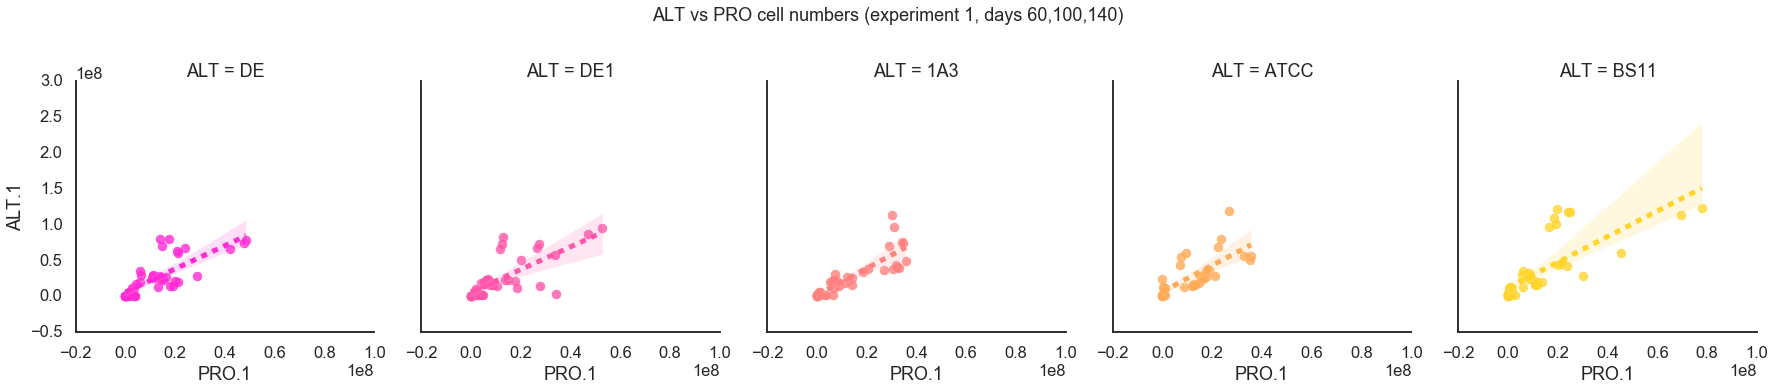

In [26]:
sns.lmplot(data=df.loc[df.experiment=='exp1'], 
           x='PRO.1', y='ALT.1', col='ALT', hue='ALT', legend='full',
           col_order=aorder, hue_order=aorder, palette=apallete,
           #aspect=1.4, #markers=True,
           #x_ci='sd',
           scatter=True,
           scatter_kws=dict(s=80),
           line_kws=dict(linewidth=5, linestyle='dashed'),
           truncate=True
          )
plt.suptitle('ALT vs PRO cell numbers (experiment 1, days 60,100,140)', y=1.1)
#plt.ylabel('Number of ORFs')

Text(0.5, 1.1, 'FL vs PRO cell numbers (experiment 1, days 60,100,140)')

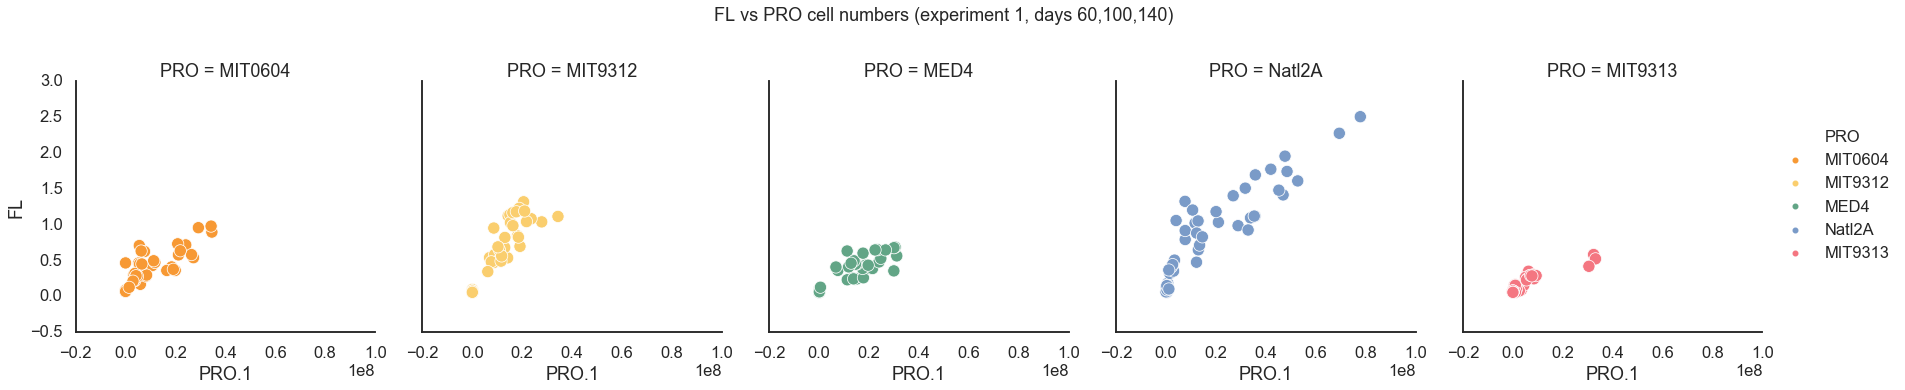

In [27]:
sns.relplot(data=df.loc[df.experiment=='exp1'], 
           x='PRO.1', y='FL', col='PRO', hue='PRO', legend='full',
           col_order=porder, hue_order=porder, palette=ppallete,
           #col_order=porder, palette=ppallete,
           #aspect=1.4, #markers=True,
           #x_ci='sd',
           s=150,
           #scatter=True,
           #scatter_kws=dict(s=80),
           #line_kws=dict(linewidth=5, linestyle='dashed'),
           #truncate=True
          )
plt.suptitle('FL vs PRO cell numbers (experiment 1, days 60,100,140)', y=1.1)
#plt.ylabel('Number of ORFs')

Text(0.5, 1.1, 'FL vs PRO cell numbers (experiment 1, days 60,100,140)')

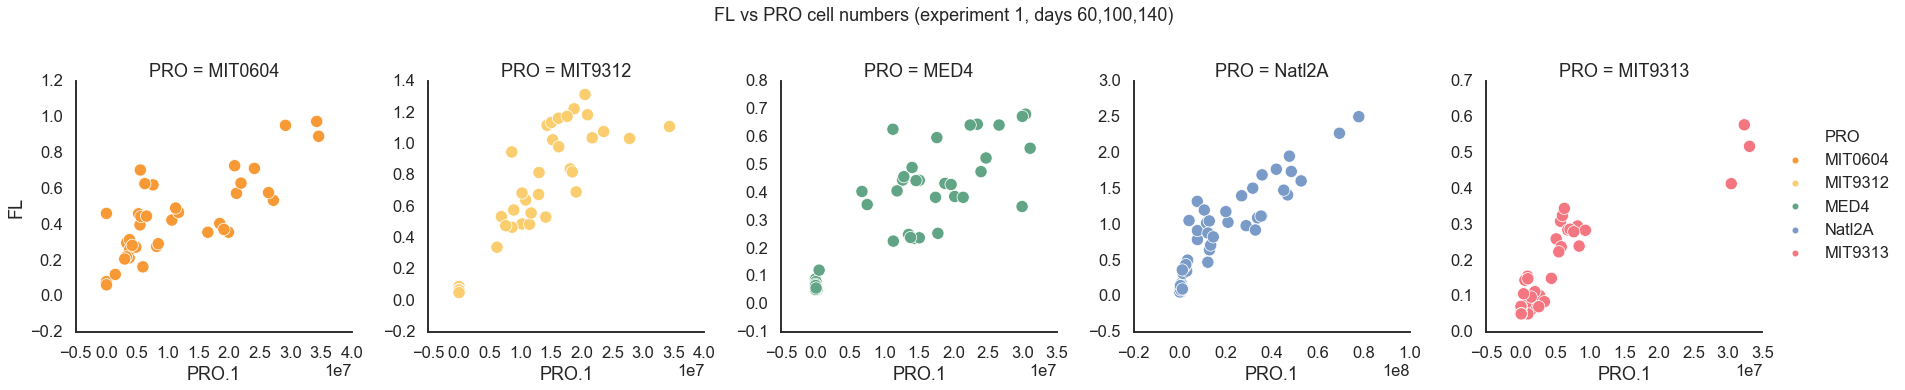

In [28]:
sns.relplot(data=df.loc[df.experiment=='exp1'], 
           x='PRO.1', y='FL', col='PRO', hue='PRO', legend='full',
           col_order=porder, hue_order=porder, palette=ppallete,
           #col_order=porder, palette=ppallete,
           #aspect=1.4, #markers=True,
           #x_ci='sd',
           s=150,
           #scatter=True,
           #scatter_kws=dict(s=80),
           #line_kws=dict(linewidth=5, linestyle='dashed'),
           #truncate=True
                        facet_kws=dict(sharex=False, sharey=False),

          )
plt.suptitle('FL vs PRO cell numbers (experiment 1, days 60,100,140)', y=1.1)
#plt.ylabel('Number of ORFs')

Text(0.5, 1.1, 'FL vs PRO cell numbers (experiment 1, days 60,100,140)')

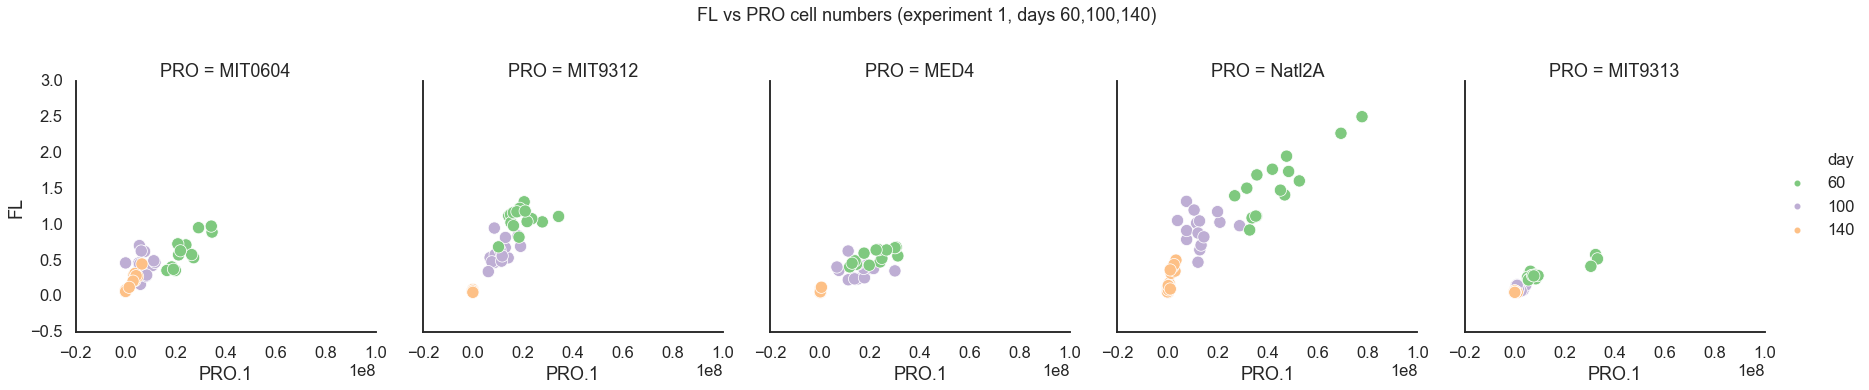

In [29]:
sns.relplot(data=df.loc[df.experiment=='exp1'], 
           x='PRO.1', y='FL', col='PRO', hue='day', legend='full',
           col_order=porder, #hue_order=porder, palette=ppallete,
           #col_order=porder, palette=ppallete,
           #aspect=1.4, #markers=True,
           #x_ci='sd',
           s=150,
            palette='Accent'
           #scatter=True,
           #scatter_kws=dict(s=80),
           #line_kws=dict(linewidth=5, linestyle='dashed'),
           #truncate=True
          )
plt.suptitle('FL vs PRO cell numbers (experiment 1, days 60,100,140)', y=1.1)
#plt.ylabel('Number of ORFs')

Text(0.5, 1.1, 'FL vs PRO cell numbers (experiment 1, days 60,100,140)')

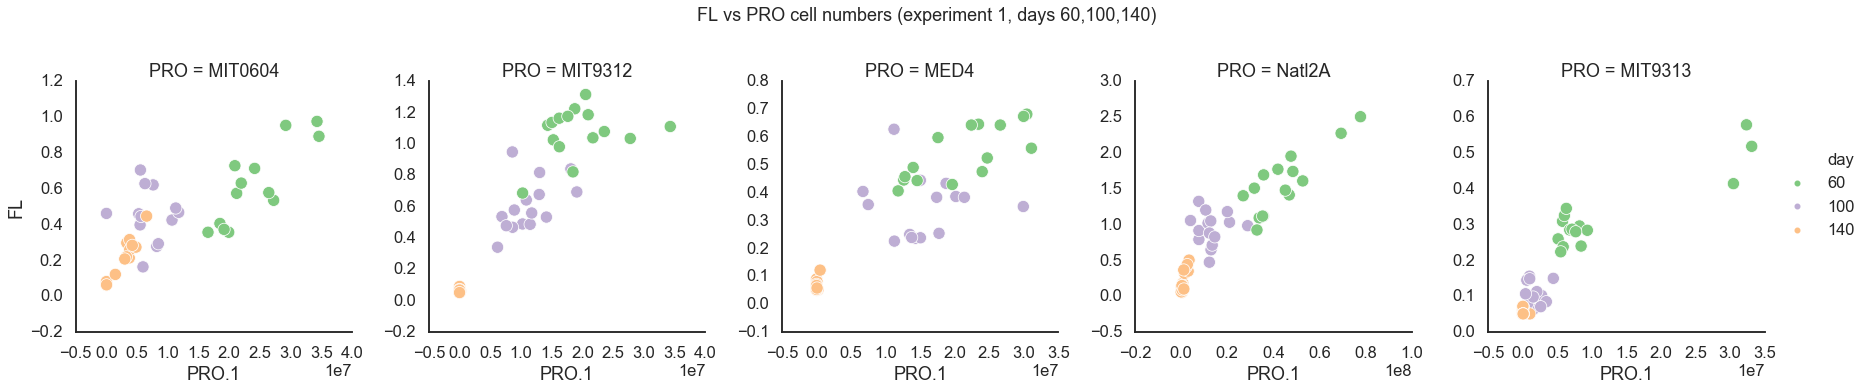

In [30]:
sns.relplot(data=df.loc[df.experiment=='exp1'], 
           x='PRO.1', y='FL', col='PRO', hue='day', legend='full',
           col_order=porder, #hue_order=porder, palette=ppallete,
           #col_order=porder, palette=ppallete,
           #aspect=1.4, #markers=True,
           #x_ci='sd',
           s=150,
            palette='Accent',
            facet_kws=dict(sharex=False, sharey=False),
           #scatter=True,
           #scatter_kws=dict(s=80),
           #line_kws=dict(linewidth=5, linestyle='dashed'),
           #truncate=True
    
          )
plt.suptitle('FL vs PRO cell numbers (experiment 1, days 60,100,140)', y=1.1)
#plt.ylabel('Number of ORFs')

Text(0.5, 1.1, 'FL vs PRO cell numbers (experiment 1, days 60,100,140)')

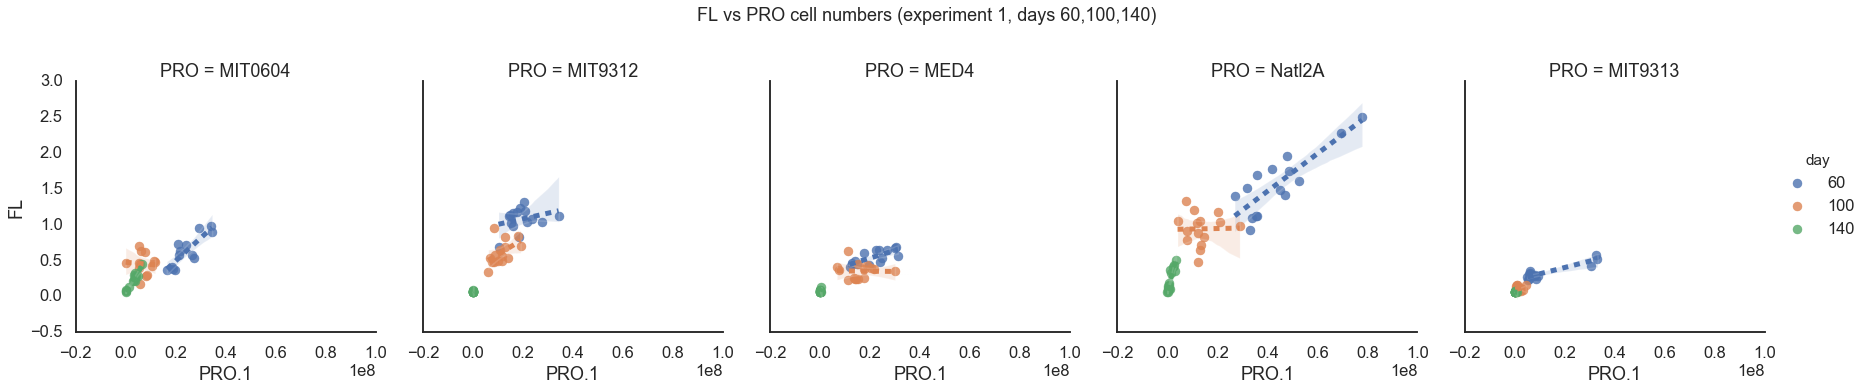

In [31]:
sns.lmplot(data=df.loc[df.experiment=='exp1'], 
           x='PRO.1', y='FL', col='PRO', hue='day', legend='full',
           col_order=porder, #hue_order=porder, palette=ppallete,
           #col_order=porder, palette=ppallete,
           #aspect=1.4, #markers=True,
           #x_ci='sd',
           scatter=True,
           scatter_kws=dict(s=80),
           line_kws=dict(linewidth=5, linestyle='dashed'),
           truncate=True
          )
plt.suptitle('FL vs PRO cell numbers (experiment 1, days 60,100,140)', y=1.1)
#plt.ylabel('Number of ORFs')

Text(0.5, 1.1, 'FL vs PRO cell numbers (experiment 1, days 60,100,140)')

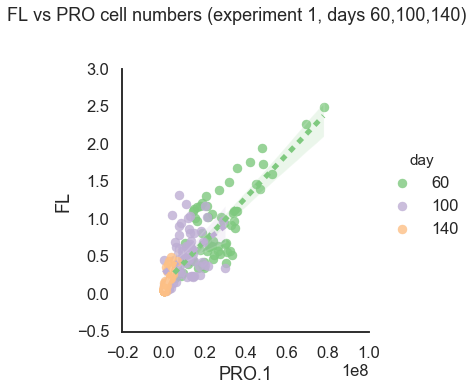

In [32]:
sns.lmplot(data=df.loc[df.experiment=='exp1'], 
           x='PRO.1', y='FL', #col='PRO', hue='PRO', legend='full',
           hue='day',
           #col_order=porder, palette=ppallete,
           #aspect=1.4, #markers=True,
           #x_ci='sd',
           scatter=True,
           scatter_kws=dict(s=80),
           line_kws=dict(linewidth=5, linestyle='dashed'),
           truncate=True,
           palette='Accent'
           
          )
plt.suptitle('FL vs PRO cell numbers (experiment 1, days 60,100,140)', y=1.1)
#plt.ylabel('Number of ORFs')

Text(0.5, 1.1, 'FL vs PRO cell numbers (experiment 1, days 60,100,140)')

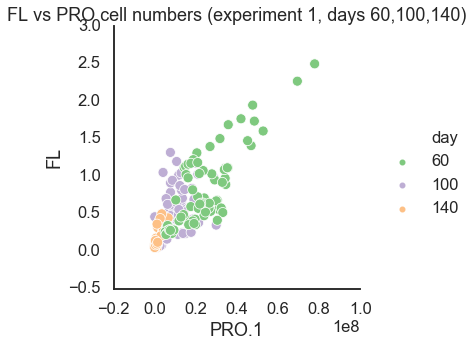

In [33]:
sns.relplot(data=df.loc[df.experiment=='exp1'], 
           x='PRO.1', y='FL', #col='PRO', hue='PRO', 
            legend='full',
           hue='day',
            s=100,
            palette='Accent'
           #col_order=porder, palette=ppallete,
           #aspect=1.4, #markers=True,
           #x_ci='sd',
           #scatter=True,
           #scatter_kws=dict(s=80),
           #line_kws=dict(linewidth=5, linestyle='dashed'),
           #truncate=True
          )

plt.title('FL vs PRO cell numbers (experiment 1, days 60,100,140)', y=1.1)
#plt.ylabel('Number of ORFs')

Text(0.5, 1.1, 'ALT cells vs PRO cell numbers (experiment 1, days 60,100,140)')

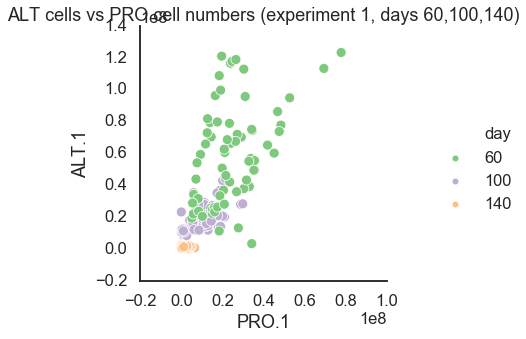

In [34]:
sns.relplot(data=df.loc[df.experiment=='exp1'], 
           x='PRO.1', y='ALT.1', #col='PRO', hue='PRO', 
            legend='full',
           hue='day',
            s=100,
            palette='Accent'
           #col_order=porder, palette=ppallete,
           #aspect=1.4, #markers=True,
           #x_ci='sd',
           #scatter=True,
           #scatter_kws=dict(s=80),
           #line_kws=dict(linewidth=5, linestyle='dashed'),
           #truncate=True
          )

plt.title('ALT cells vs PRO cell numbers (experiment 1, days 60,100,140)', y=1.1)
#plt.ylabel('Number of ORFs')

Text(0.5, 1.1, 'FL vs PRO cell numbers (experiment 1, days 60,100,140)')

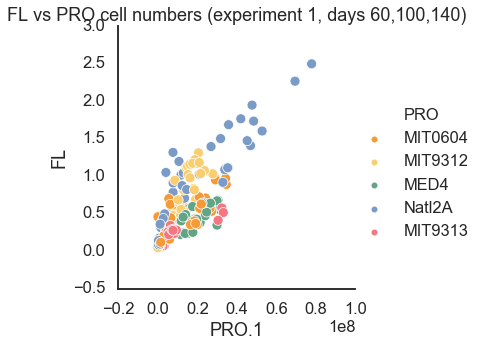

In [35]:
sns.relplot(data=df.loc[df.experiment=='exp1'], 
           x='PRO.1', y='FL', #col='PRO', hue='PRO', 
            legend='full',
           hue='PRO',
            s=100,
            #palette=ppallete
           hue_order=porder, palette=ppallete,
           #aspect=1.4, #markers=True,
           #x_ci='sd',
           #scatter=True,
           #scatter_kws=dict(s=80),
           #line_kws=dict(linewidth=5, linestyle='dashed'),
           #truncate=True
          )
plt.title('FL vs PRO cell numbers (experiment 1, days 60,100,140)', y=1.1)
#plt.suptitle('FL vs PRO cell numbers (experiment 1, days 60,100,140)', y=1.1)
#plt.ylabel('Number of ORFs')

In [36]:
import statsmodels.api as sm

Text(0.5, 1, 'pearson correlation of FL, ALT cells, PRO cells,\n experiment 1 days 60,100,140')

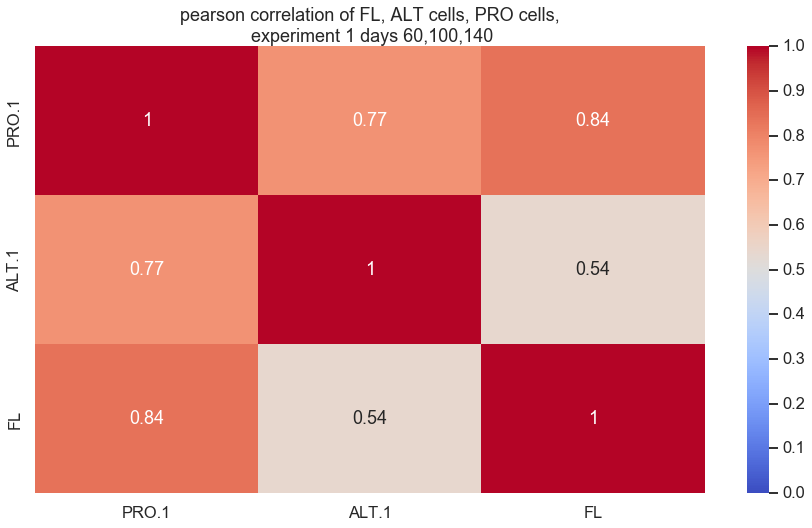

In [37]:
sns.heatmap(df.loc[df.experiment=='exp1', ['PRO.1', 'ALT.1', 'FL']].corr(), 
            cmap='coolwarm', annot=True, vmin=0)
plt.title('pearson correlation of FL, ALT cells, PRO cells,\n experiment 1 days 60,100,140')

Text(0.5, 1.1, 'pearson correlation of FL, ALT cells, PRO cells, experiment 1 days 60,100,140')

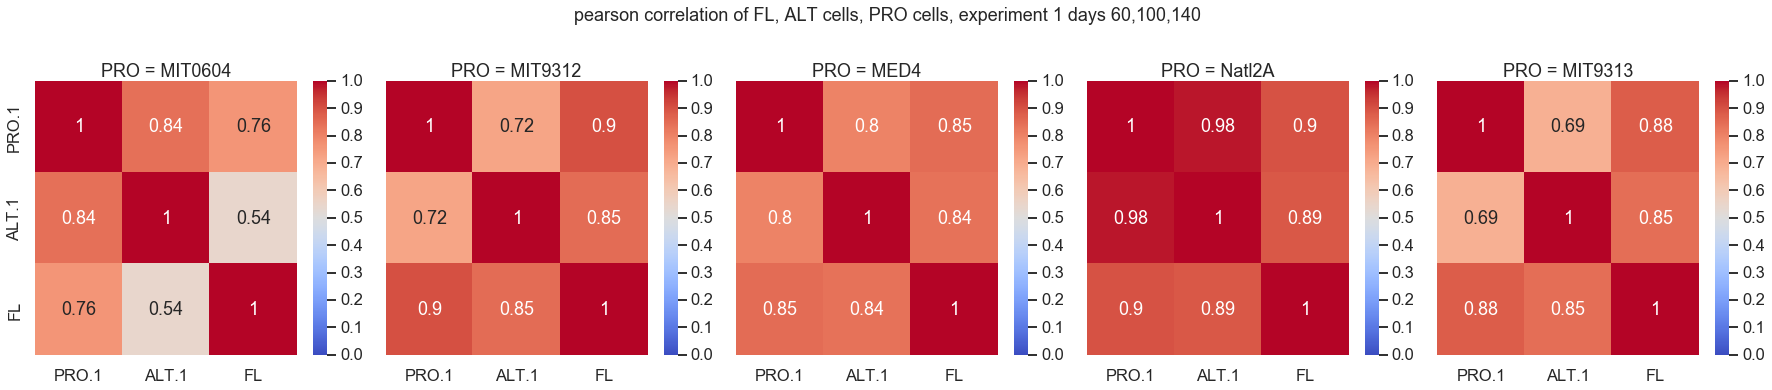

In [38]:
sns.set_context('talk')
g = sns.FacetGrid(df.loc[df.experiment=='exp1', ['PRO','ALT','PRO.1', 'ALT.1', 'FL']], 
                  col='PRO', col_order=porder, height=5)
g.map_dataframe(lambda data, color: sns.heatmap(data.corr(), linewidths=0, cmap='coolwarm', annot=True, vmin=0))
plt.suptitle('pearson correlation of FL, ALT cells, PRO cells, experiment 1 days 60,100,140', y=1.1)

Text(0.5, 1.1, 'pearson correlation of FL, ALT cells, PRO cells, experiment 1 days 60,100,140')

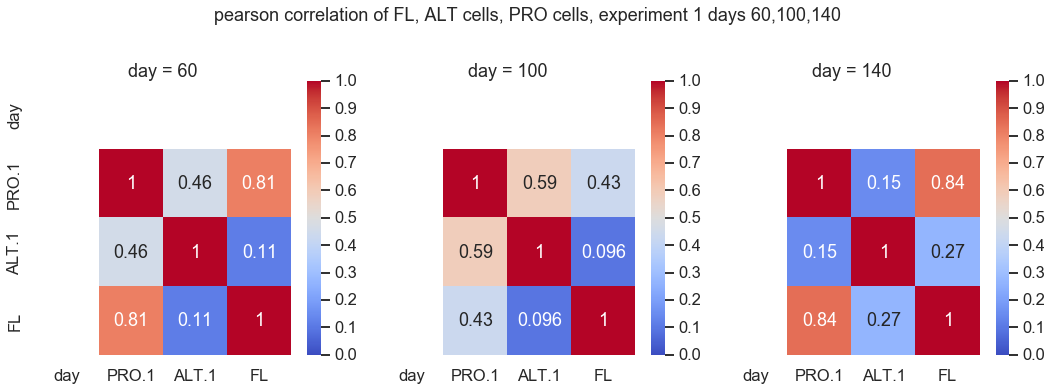

In [39]:
sns.set_context('talk')
g = sns.FacetGrid(df.loc[df.experiment=='exp1', ['PRO','ALT','day','PRO.1', 'ALT.1', 'FL']], 
                  col='day',  height=5)
g.map_dataframe(lambda data, color: sns.heatmap(data.corr(), linewidths=0, cmap='coolwarm', annot=True, vmin=0))
plt.suptitle('pearson correlation of FL, ALT cells, PRO cells, experiment 1 days 60,100,140', y=1.1)

Text(0.5, 0.98, 'pearson correlation of FL, ALT cells, PRO cells,\n experiment 1 days 60,100,140')

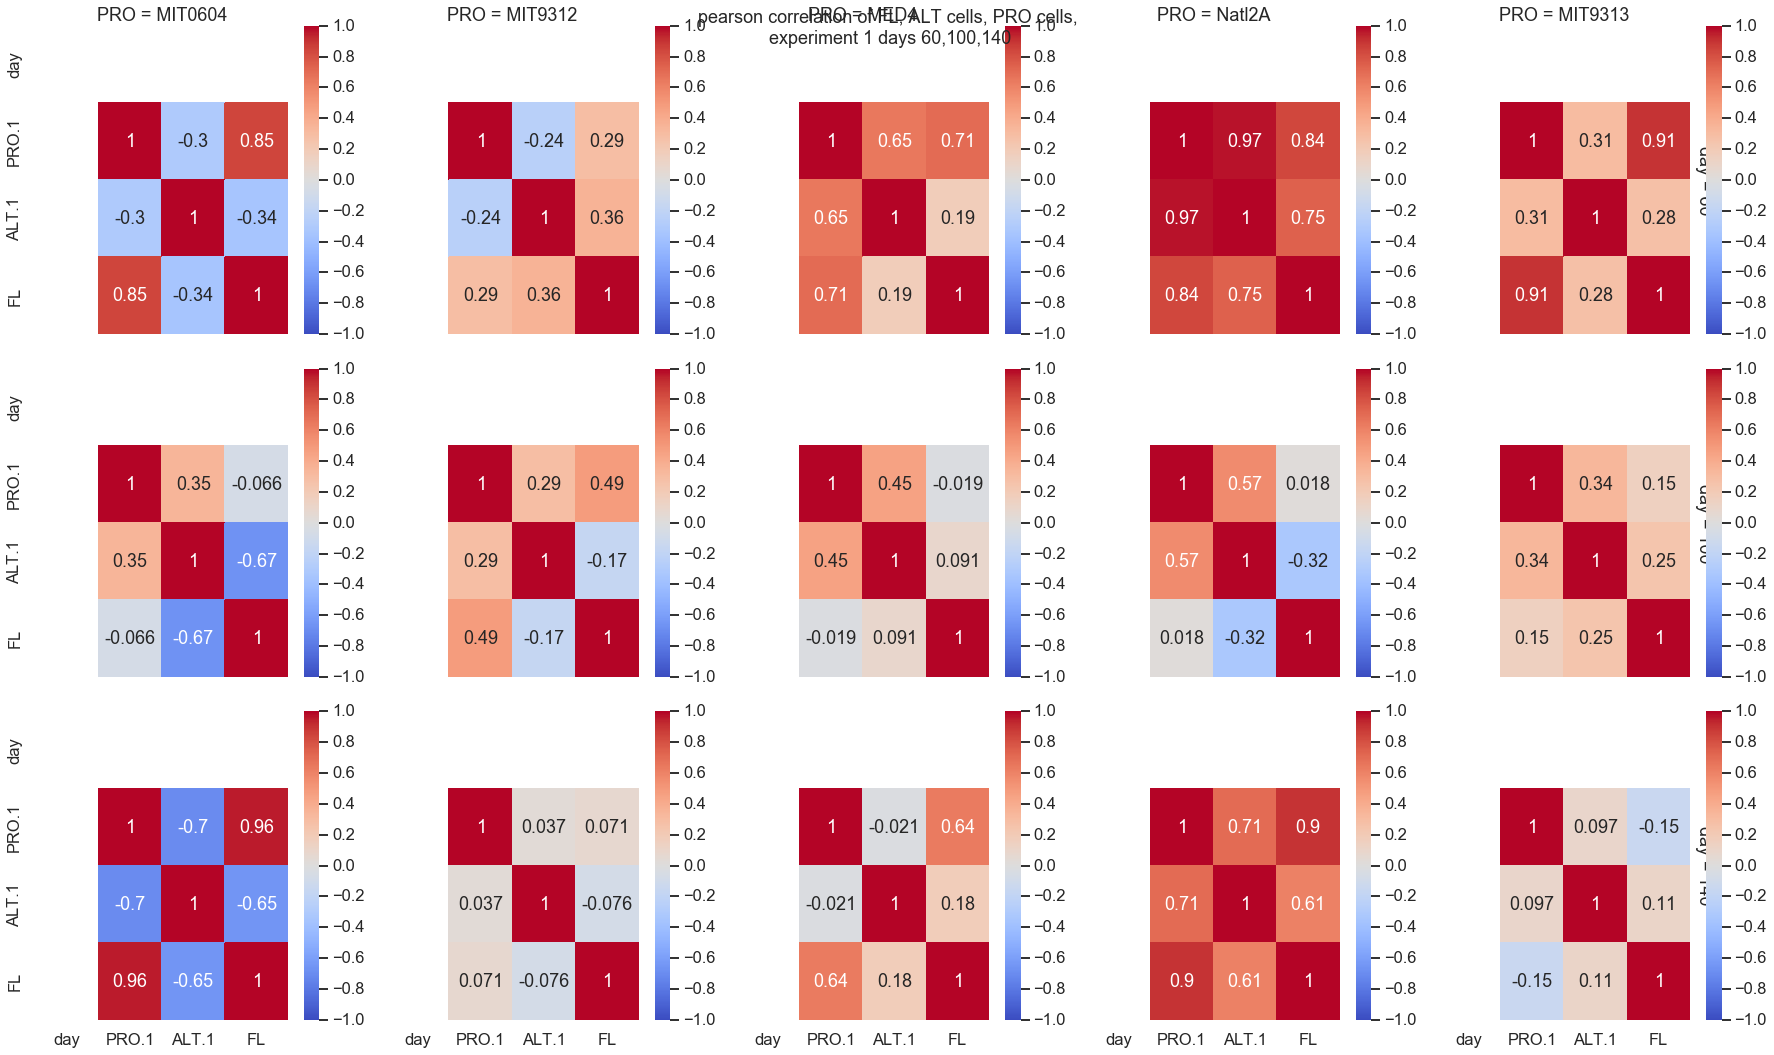

In [40]:
sns.set_context('talk')
g = sns.FacetGrid(df.loc[df.experiment=='exp1', ['PRO','ALT','day','PRO.1', 'ALT.1', 'FL']], row='day',
                  col='PRO', col_order=porder, height=5,
                  
                 margin_titles=True)
g.map_dataframe(lambda data, color: sns.heatmap(data.corr(), linewidths=0, cmap='coolwarm', annot=True, vmin=-1))
plt.suptitle('pearson correlation of FL, ALT cells, PRO cells,\n experiment 1 days 60,100,140')

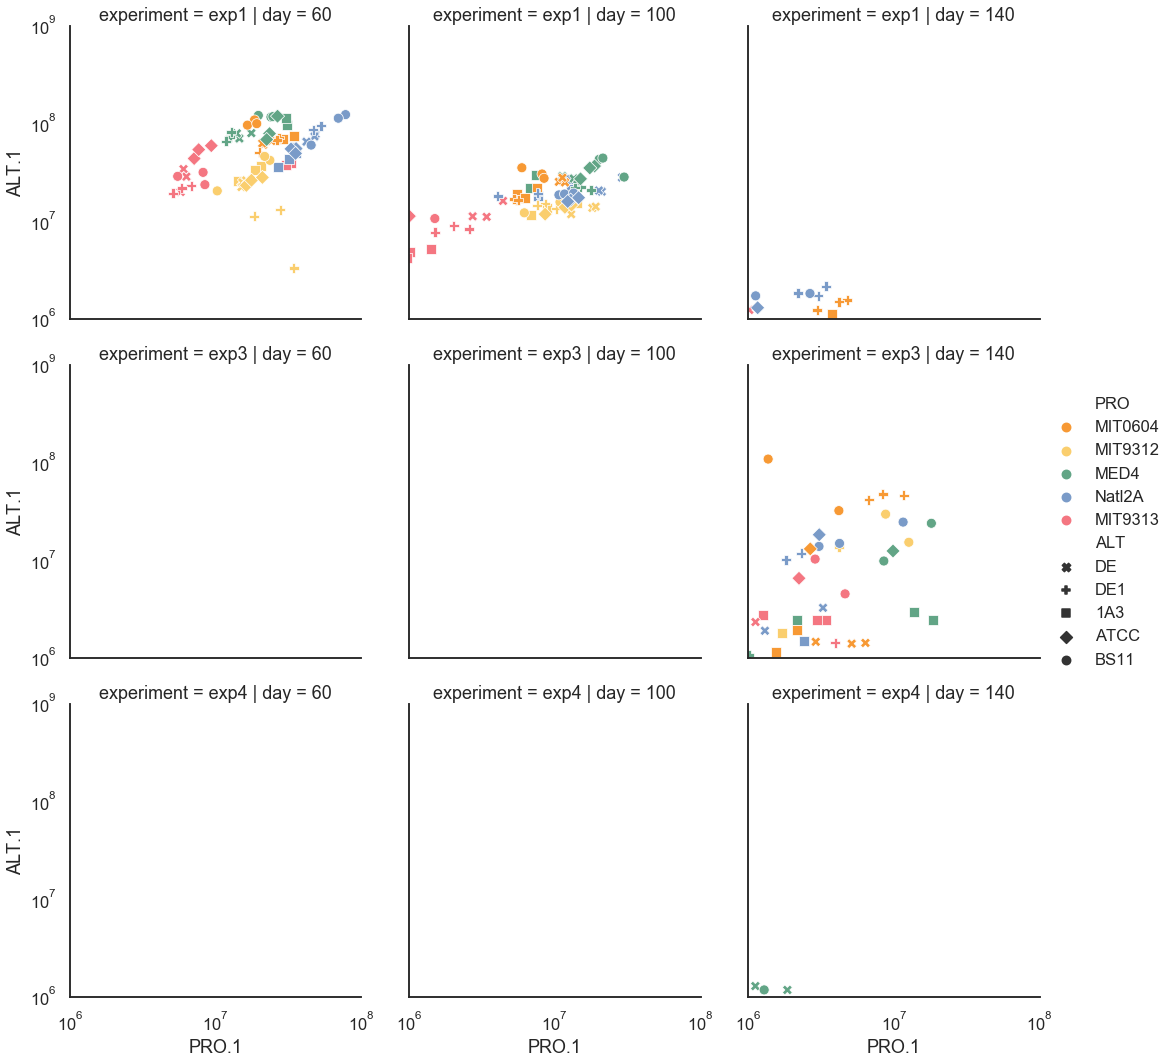

In [41]:
g= sns.relplot(data=df, x='PRO.1', y='ALT.1', col='day', row='experiment', hue='PRO', style='ALT', s=100,
            hue_order=porder, palette=ppallete, style_order=aorder, markers=amarkers,
           )
g.set(yscale='log')
g.set(xscale='log')
for lh in g._legend.legendHandles: 
    lh.set_sizes([70])

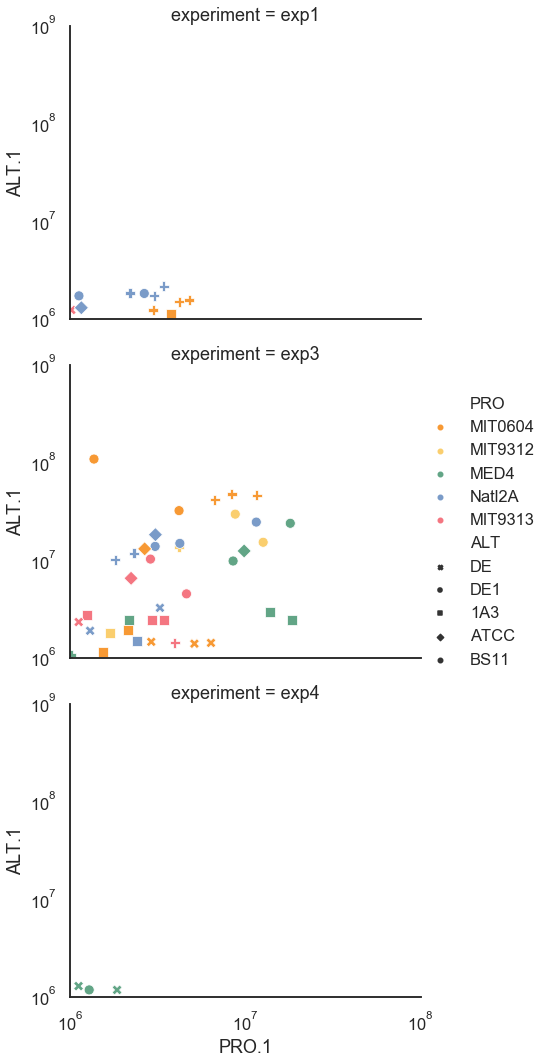

In [42]:
g =sns.relplot(data=df.loc[df['day'] == 140], 
            x='PRO.1', y='ALT.1', #col='day', 
            row='experiment', hue='PRO', style='ALT', s=100,
            hue_order=porder, palette=ppallete, style_order=aorder, markers=amarkers, aspect=1.3
               
           )
g.set(yscale='log')
g.set(xscale='log')

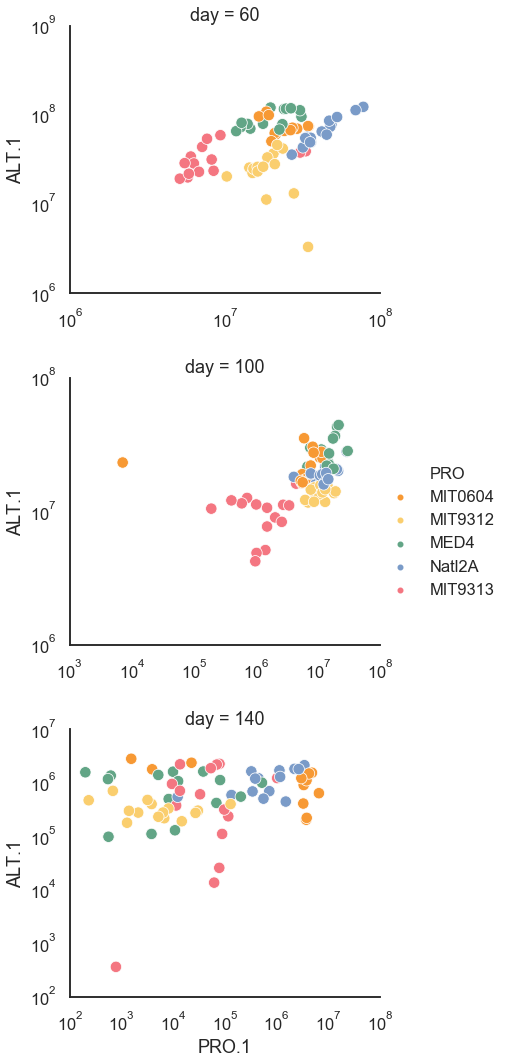

In [43]:
g =sns.relplot(data=df.loc[df['experiment'] == 'exp1'], 
            x='PRO.1', y='ALT.1', #col='day', 
            row='day', hue='PRO', #style='ALT', 
               s=130,
            hue_order=porder, palette=ppallete, #style_order=aorder, markers=amarkers, 
               aspect=1.3,
               facet_kws=dict(sharex=False, sharey=False)
               
           )
g.set(yscale='log')
g.set(xscale='log')

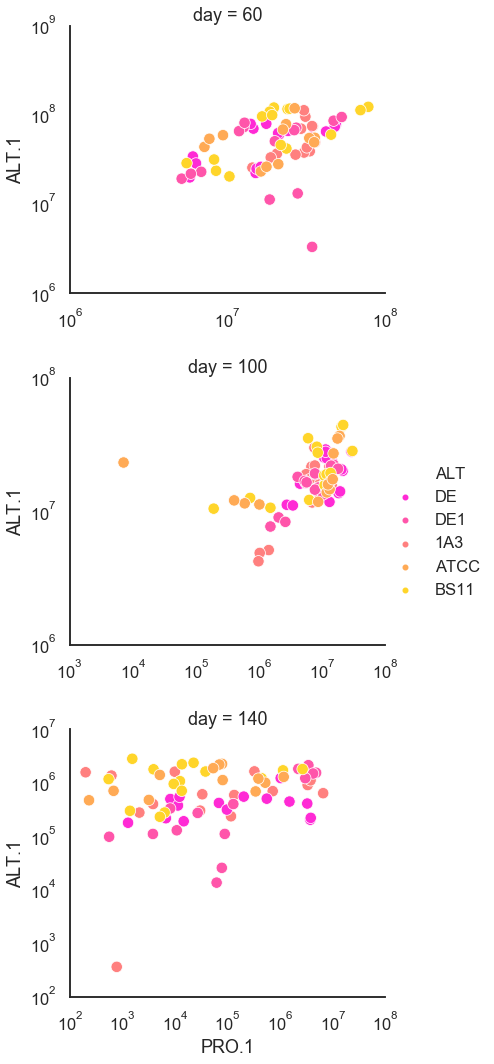

In [44]:
g =sns.relplot(data=df.loc[df['experiment'] == 'exp1'], 
            x='PRO.1', y='ALT.1', #col='day', 
            row='day', hue='ALT', #style='ALT', 
               s=130,
            hue_order=aorder, palette=apallete, #style_order=aorder, markers=amarkers, 
               aspect=1.3,
               facet_kws=dict(sharex=False, sharey=False)
               
           )
g.set(yscale='log')
g.set(xscale='log')

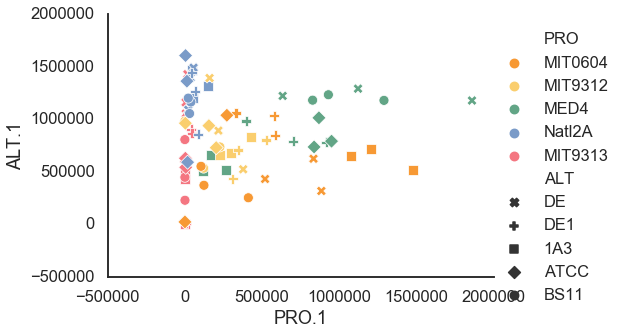

In [45]:
g =sns.relplot(data=df.loc[(df['experiment'] == 'exp4')],
            x='PRO.1', y='ALT.1', #col='day', row='experiment', 
            hue_order=porder, palette=ppallete, style_order=aorder, markers=amarkers,
            hue='PRO', style='ALT', s=100, aspect=1.5)
#g.set(yscale='log')
#g.set(xscale='log')
for lh in g._legend.legendHandles: 
    lh.set_sizes([70])

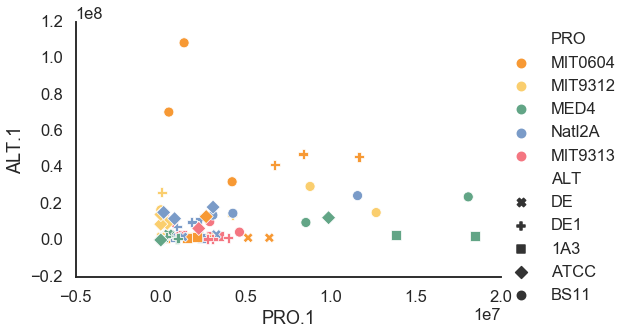

In [46]:
g =sns.relplot(data=df.loc[(df['experiment'] == 'exp3')],
            x='PRO.1', y='ALT.1', #col='day', row='experiment', 
            hue_order=porder, palette=ppallete, style_order=aorder, markers=amarkers,
            hue='PRO', style='ALT', s=100, aspect=1.5)
#g.set(yscale='log')
#g.set(xscale='log')
for lh in g._legend.legendHandles: 
    lh.set_sizes([70])

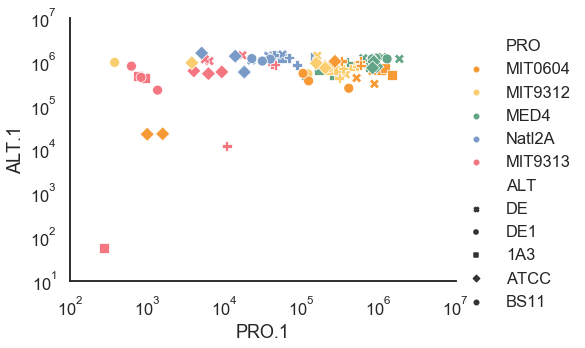

In [47]:
g =sns.relplot(data=df.loc[(df['experiment'] == 'exp4')],
            x='PRO.1', y='ALT.1', #col='day', row='experiment', 
            hue_order=porder, palette=ppallete, style_order=aorder, markers=amarkers,
            hue='PRO', style='ALT', s=100, aspect=1.5)
g.set(yscale='log')
g.set(xscale='log')

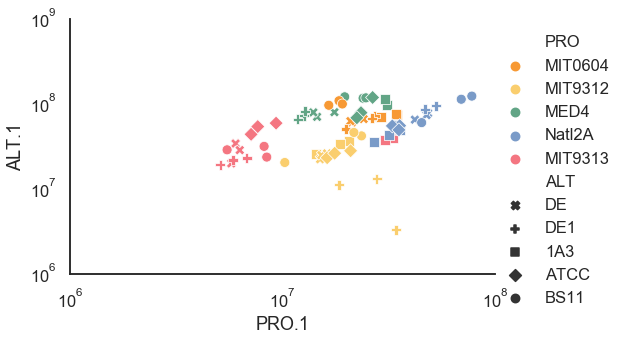

In [48]:
g =sns.relplot(data=df.loc[(df['day'] == 60)],
            x='PRO.1', y='ALT.1', #col='day', row='experiment', 
            hue_order=porder, palette=ppallete, style_order=aorder, markers=amarkers,
            hue='PRO', style='ALT', s=100, aspect=1.5)
g.set(yscale='log')
g.set(xscale='log')
for lh in g._legend.legendHandles: 
    lh.set_sizes([70])

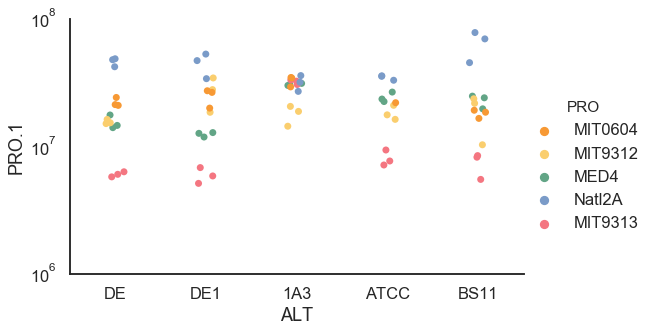

In [49]:
g = sns.catplot(data=df.loc[df.day==60], 
          x='ALT', y='PRO.1', 
                hue='PRO', 
                aspect=1.5,
                hue_order=porder,
               order=aorder,
                palette=ppallete,
                s=7,

               )
g.set(yscale='log')


C:\Users\Osnat\Anaconda3\lib\site-packages\seaborn\categorical.py:1326: RuntimeWarning: invalid value encountered in less
  off_low = points < low_gutter
C:\Users\Osnat\Anaconda3\lib\site-packages\seaborn\categorical.py:1330: RuntimeWarning: invalid value encountered in greater
  off_high = points > high_gutter


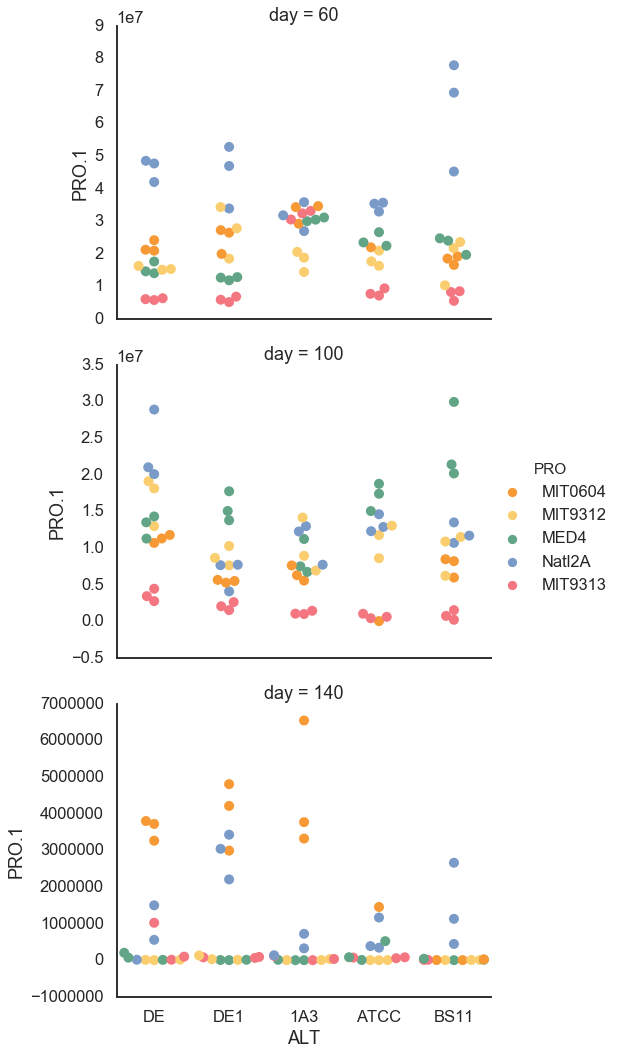

In [50]:
g = sns.catplot(data=df.loc[df.experiment=='exp1'], 
          x='ALT', y='PRO.1', 
                hue='PRO', 
                aspect=1.5,
                hue_order=porder,
               order=aorder,
                palette=ppallete,
                s=10,
                #kind='swarm',
                row='day',
                sharey=False,
               #facet_kws=dict(sharey=False)
                kind='swarm',
               )
#g.set(yscale='log')
#plt.ylim((1,1.5e8))
#for lh in g._legend.legendHandles: 
#    lh.set_sizes([70])

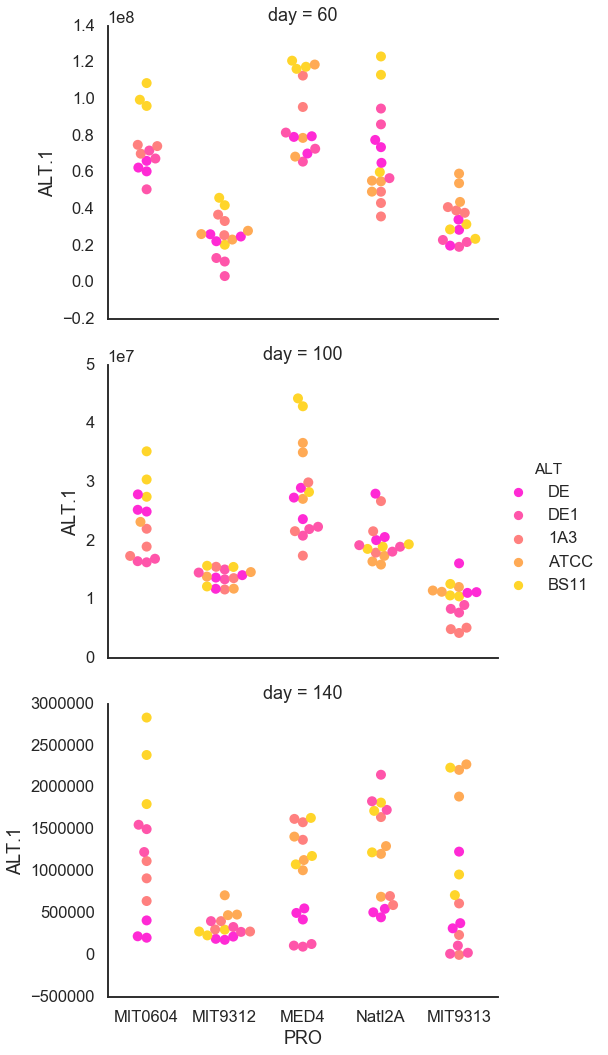

In [51]:
g = sns.catplot(data=df.loc[df.experiment=='exp1'], 
          x='PRO', y='ALT.1', 
                hue='ALT', 
                aspect=1.5,
                hue_order=aorder,
               order=porder,
                palette=apallete,
                s=10,
                row='day',
                sharey=False,
                kind='swarm',
                
               )
#plt.ylim((1,1.5e8))
#g.set(yscale='log')
#for lh in g._legend.legendHandles: 
#    lh.set_sizes([70])

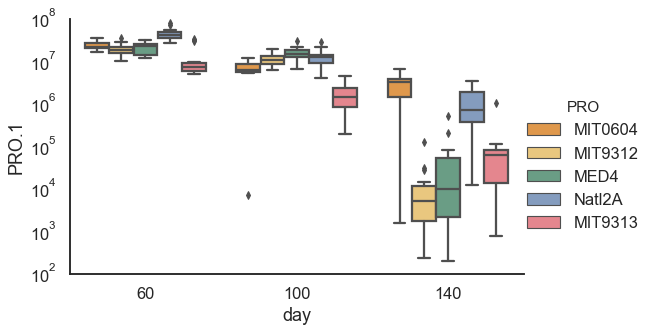

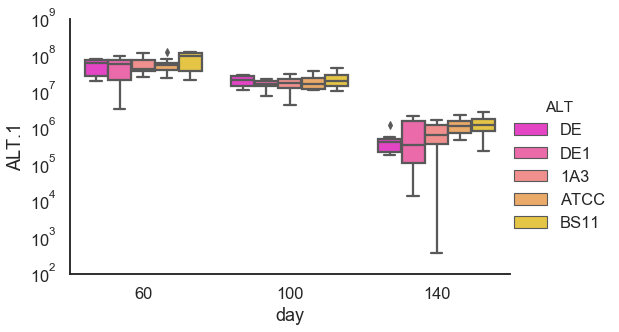

In [57]:
g = sns.catplot(data=df.loc[df.experiment=='exp1'], 
          x='day', y='PRO.1', 
                hue='PRO', 
                aspect=1.5,
                hue_order=porder,
               #order=porder,
                palette=ppallete,
                sharey=False,
                kind='box',
                
               )
plt.yscale('log')
g = sns.catplot(data=df.loc[df.experiment=='exp1'], 
          x='day', y='ALT.1', 
                hue='ALT', 
                aspect=1.5,
                hue_order=aorder,
               #order=porder,
                palette=apallete,
                sharey=False,
                kind='box',
                
               )
plt.yscale('log')


In [68]:
df.loc[df['ALT.1'].isna()]

,PRO,ALT,sample,PRO.1,ALT.1,experiment,day,FL
72,MIT0604,ATCC,25A,NaN,NaN,exp1,100,NaN
73,MIT0604,ATCC,25B,NaN,NaN,exp1,100,NaN
147,MIT0604,ATCC,25A,NaN,NaN,exp1,140,NaN
148,MIT0604,ATCC,25B,NaN,NaN,exp1,140,NaN
149,MIT0604,ATCC,25C,1.452120e+06,NaN,exp1,140,0.120
152,MED4,1A3,1C,2.996083e+07,NaN,exp1,60,0.672
222,MIT0604,ATCC,25A,NaN,NaN,exp1,60,NaN
223,MIT0604,ATCC,25B,NaN,NaN,exp1,60,NaN
224,MIT0604,ATCC,25C,2.194349e+07,NaN,exp1,60,0.629
297,MIT0604,ATCC,25A,7.095344e+04,NaN,exp3,140,NaN


C:\Users\Osnat\Anaconda3\lib\site-packages\seaborn\categorical.py:1326: RuntimeWarning: invalid value encountered in less
  off_low = points < low_gutter
C:\Users\Osnat\Anaconda3\lib\site-packages\seaborn\categorical.py:1330: RuntimeWarning: invalid value encountered in greater
  off_high = points > high_gutter


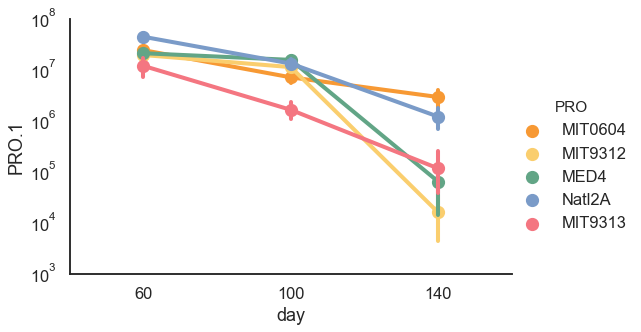

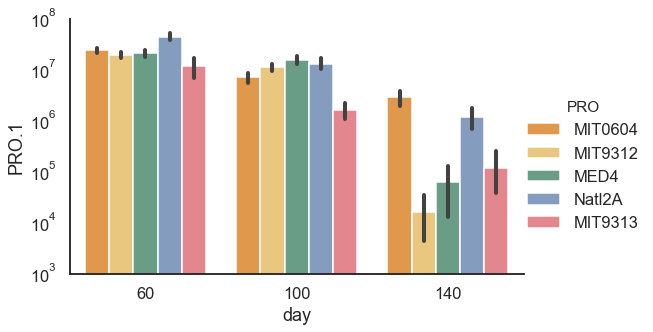

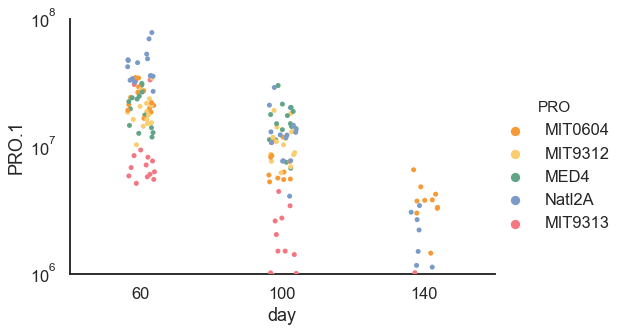

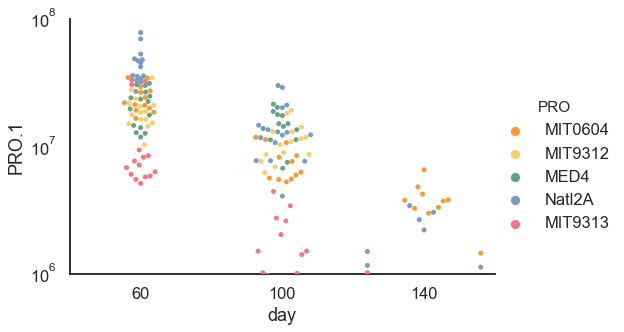

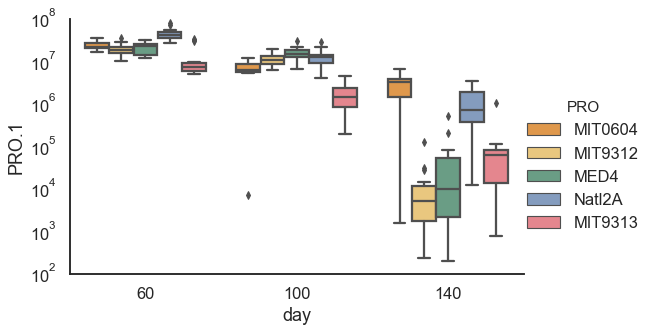

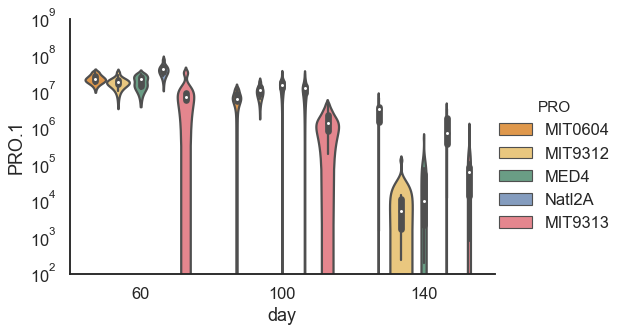

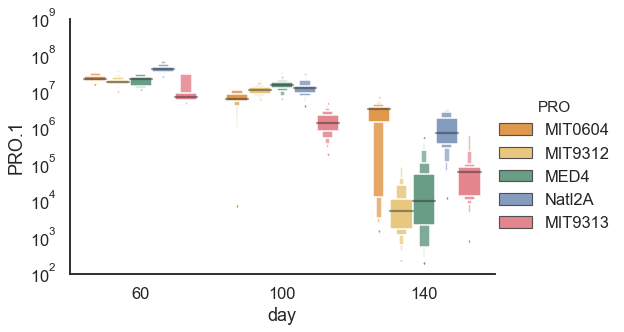

In [61]:
for k in ['point', 'bar', 'strip', 'swarm', 'box', 'violin', 'boxen']:
    g = sns.catplot(data=df.loc[df.experiment=='exp1'], 
          x='day', y='PRO.1', 
                hue='PRO', 
                aspect=1.5,
                hue_order=porder,
               #order=porder,
                palette=ppallete,
                sharey=False,
                kind=k,
                
               )
    plt.yscale('log')